In [5]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

In [6]:
# load final clean dataset
df = pd.read_csv('merged_clean_data.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95489 entries, 0 to 95488
Data columns (total 34 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   provincename                                                                       95489 non-null  object 
 1   Longitude                                                                          95489 non-null  float64
 2   Latitude                                                                           95489 non-null  float64
 3   Region.Name                                                                        95489 non-null  object 
 4   Date/Time                                                                          95489 non-null  object 
 5   Utilities                                                                          85601 non-null  flo

In [8]:
# convert 'Date/Time' to datetime format
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# convert 'GeoUID' to string
df['GeoUID'] = df['GeoUID'].astype('str')

In [9]:
# set date time as index
df.set_index('Date/Time', inplace = True)

In [10]:
# drop unnecessary columns
sectors_todrop = ['Manufacturing', 'Utilities', 'Educational services', 'Accommodation and food services', 'Other services except public administration',
                  'Public administration', 'Finance and insurance, real estate and rental and leasing', 'Professional scientific and technical services',
                  'Information culture and recreation']

df.drop(columns = sectors_todrop, inplace = True)

In [11]:
# rename columns
df.rename(columns={'Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction': 'Agriculture'}, inplace=True)

## (1) All 5 provinces ##

In [12]:
# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = df.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

In [13]:
columns = [
    'Construction',
    'Transportation and warehousing',
    'Health care and social assistance',
    'Agriculture',
    'Wholesale trade Retail trade',
    'Population',
    'Mean Max Temp (°C)',
    'Mean Min Temp (°C)',
    'Mean Temp (°C)',
    'Extr Max Temp (°C)',
    'Extr Min Temp (°C)',
    'Total Rain (mm)',
    'Total Snow (cm)',
    'Total Precip (mm)',
    'Snow Grnd Last Day (cm)',
    'Dir of Max Gust (10s deg)',
    'Spd of Max Gust (km/h)'
]

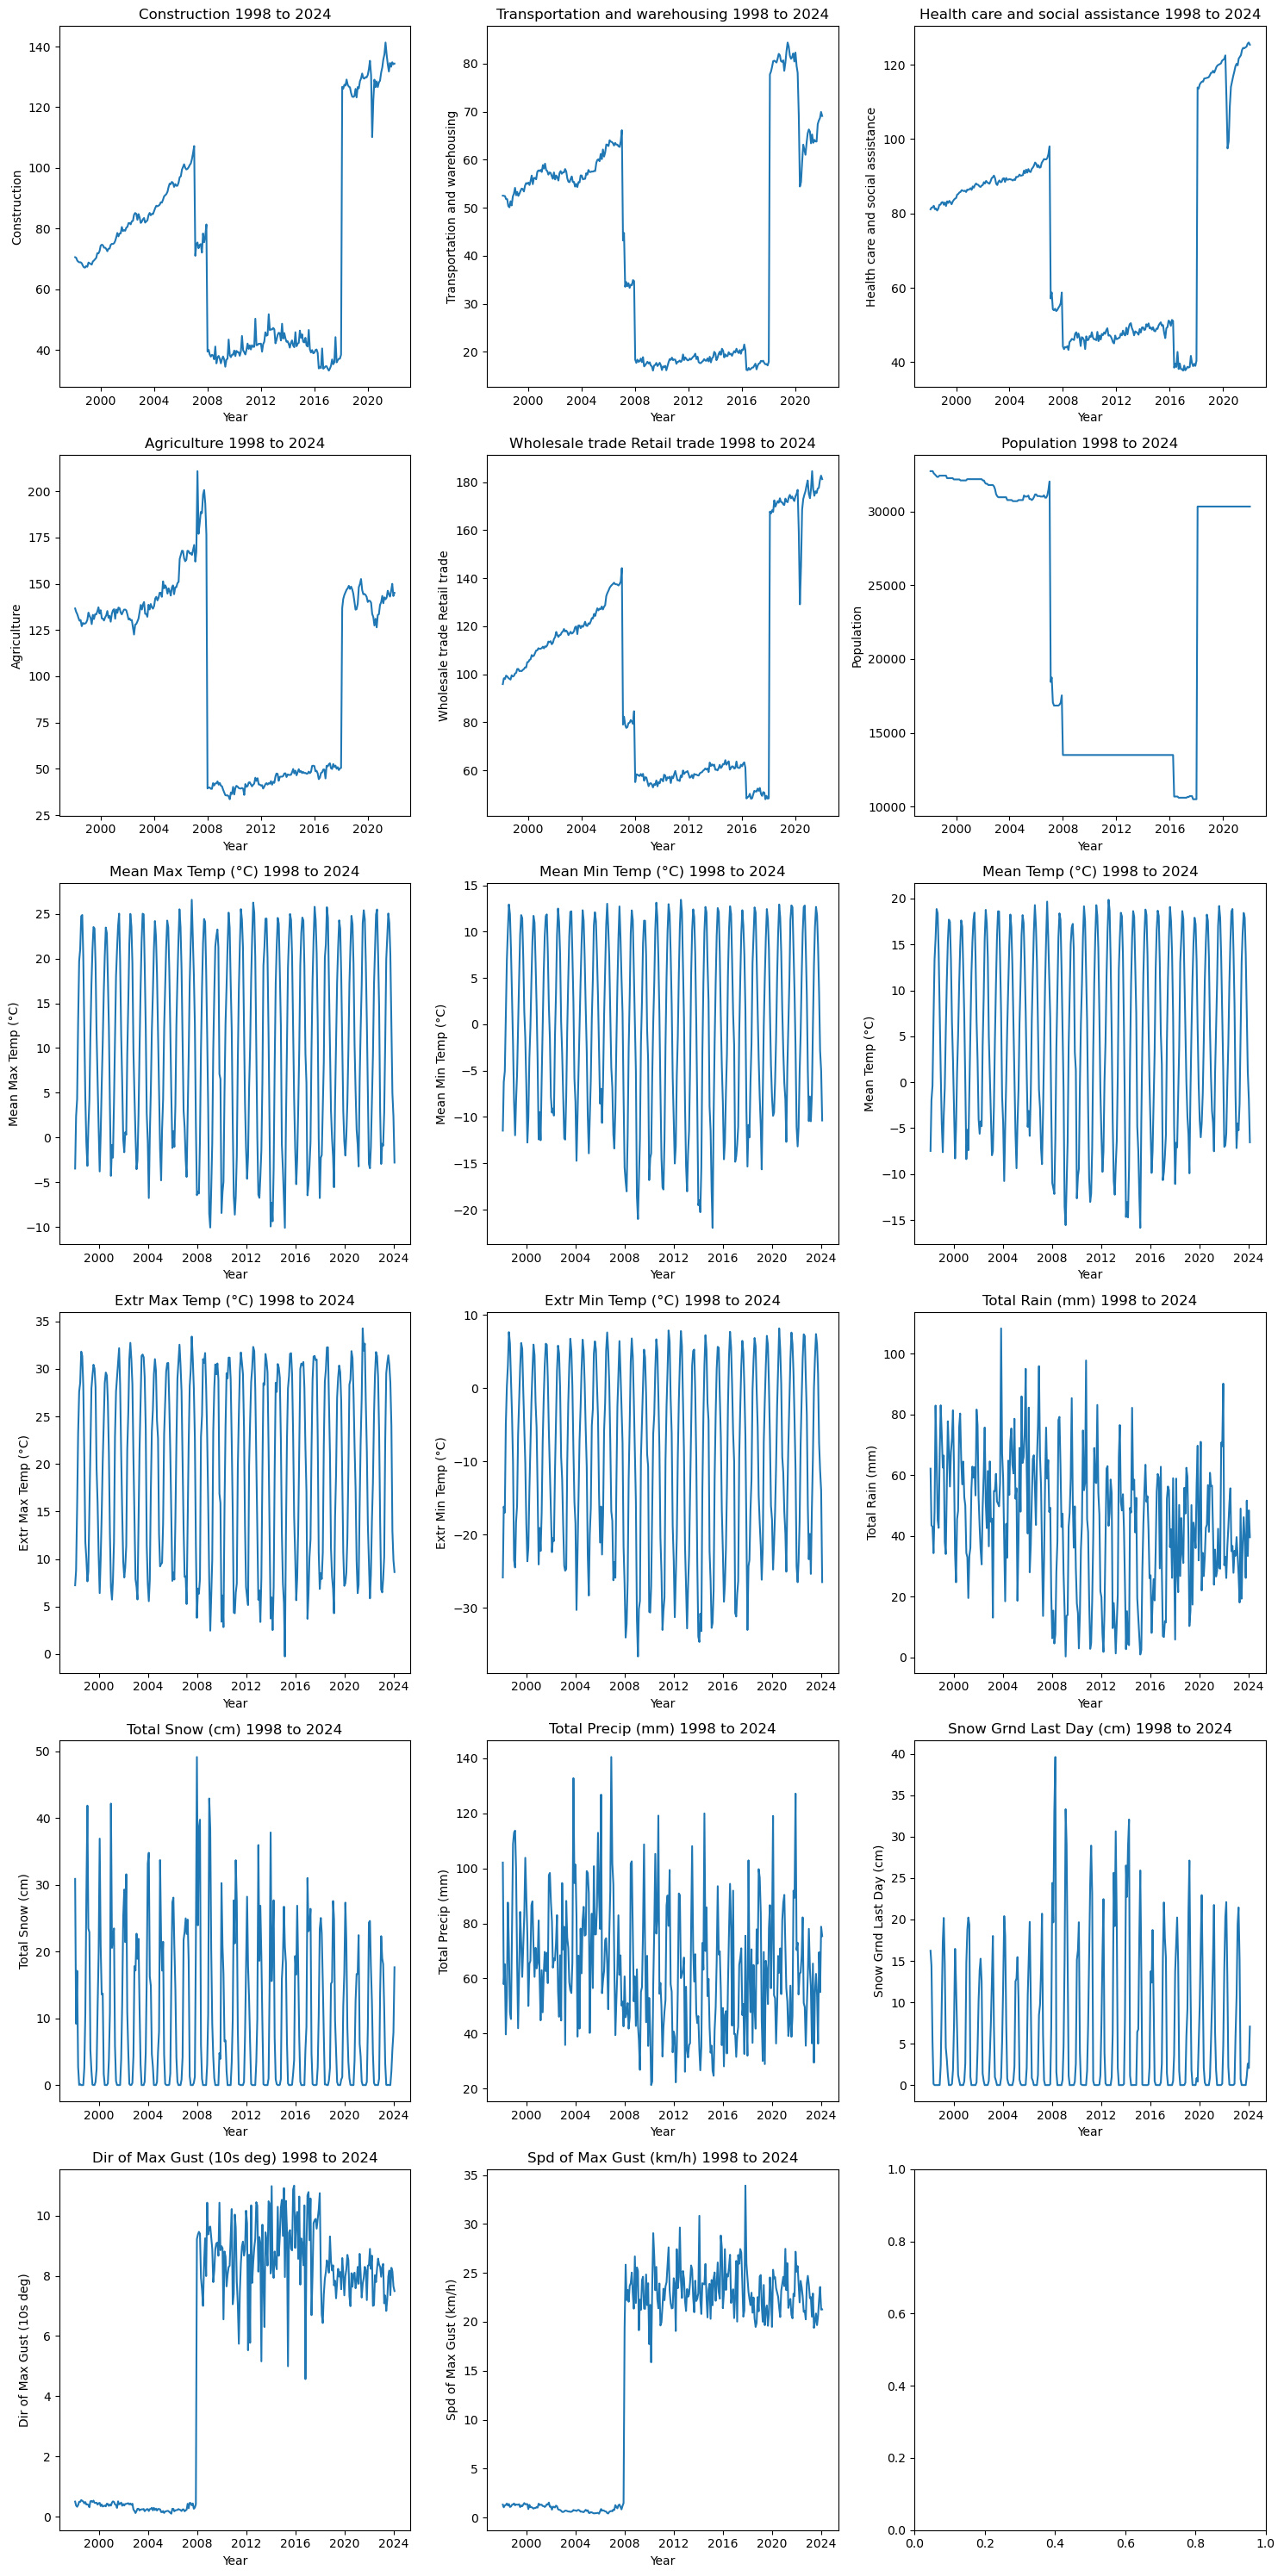

In [14]:
# plot the variables

num_cols = 3 
num_rows = (len(columns) + num_cols - 1) // num_cols  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for i, col in enumerate(columns):
    row_idx = i // num_cols
    col_idx = i % num_cols
    
    # Plot time series data
    axes[row_idx, col_idx].plot(resampled[col])
    axes[row_idx, col_idx].set_title(f'{col} 1998 to 2024')
    axes[row_idx, col_idx].set_xlabel('Year')
    axes[row_idx, col_idx].set_ylabel(col)

# Adjust layout
plt.tight_layout()
plt.show()

In [15]:
resampled.isnull().sum()

Longitude                             0
Latitude                              0
Construction                         25
Transportation and warehousing       25
Health care and social assistance    25
Agriculture                          25
Wholesale trade Retail trade         25
Population                           25
Mean Max Temp (°C)                    0
Mean Min Temp (°C)                    0
Mean Temp (°C)                        0
Extr Max Temp (°C)                    0
Extr Min Temp (°C)                    0
Total Rain (mm)                       0
Total Snow (cm)                       0
Total Precip (mm)                     0
Snow Grnd Last Day (cm)               0
Dir of Max Gust (10s deg)             0
Spd of Max Gust (km/h)                0
dtype: int64

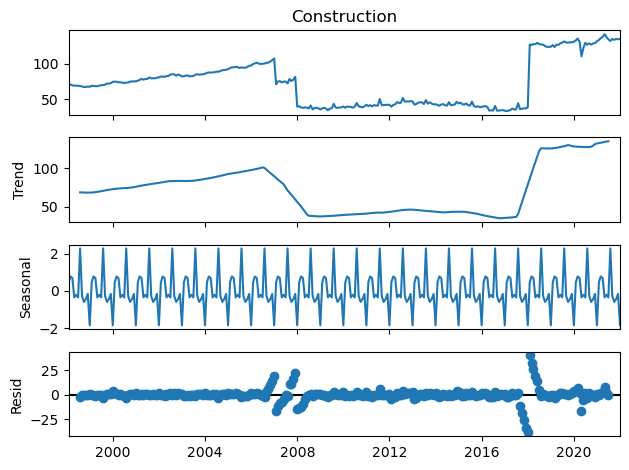

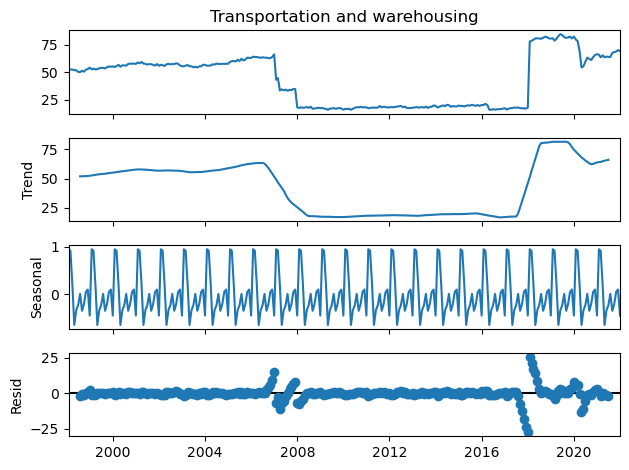

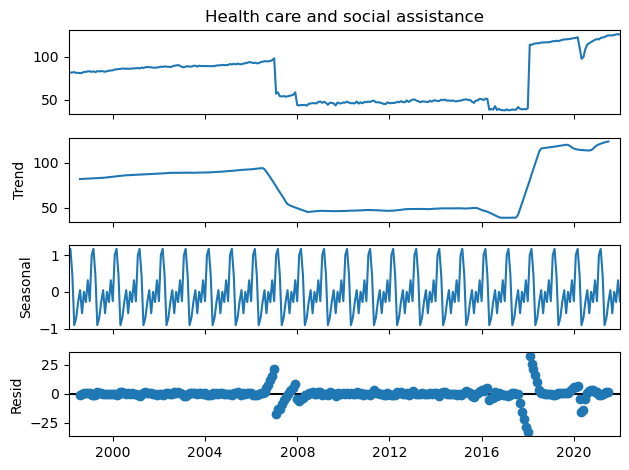

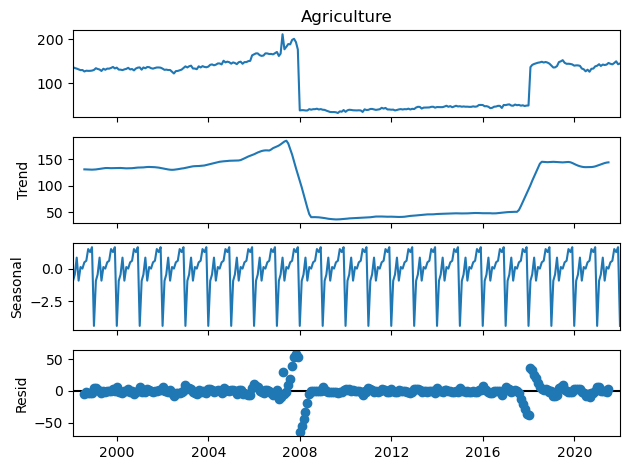

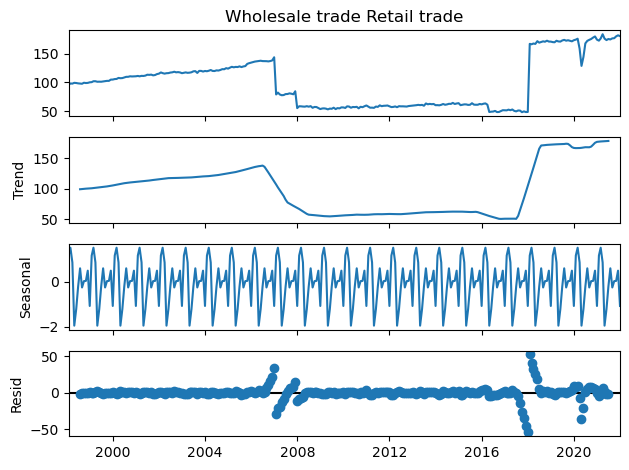

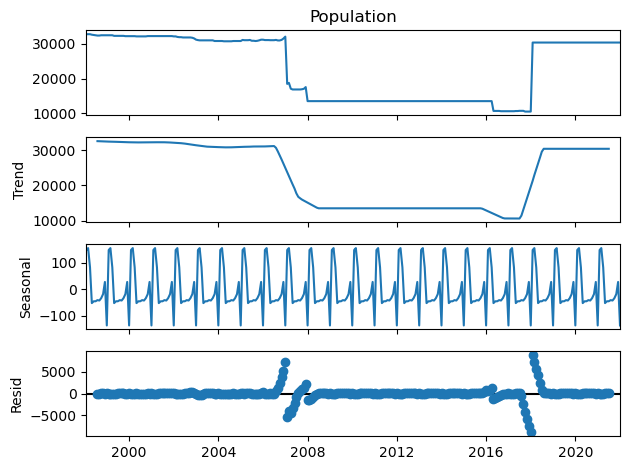

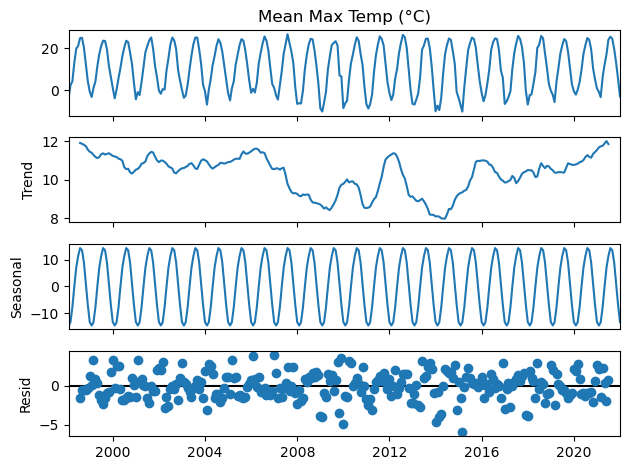

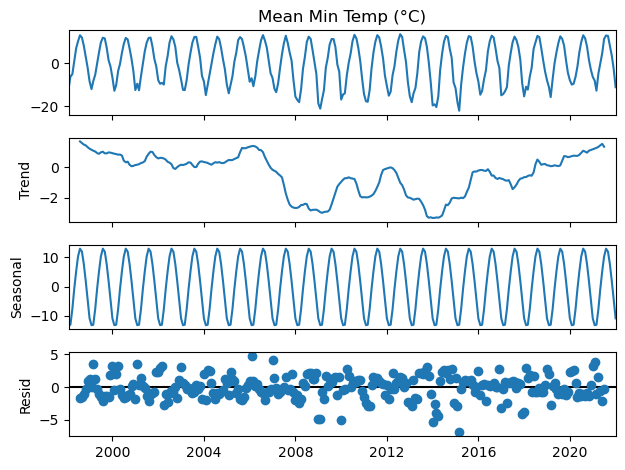

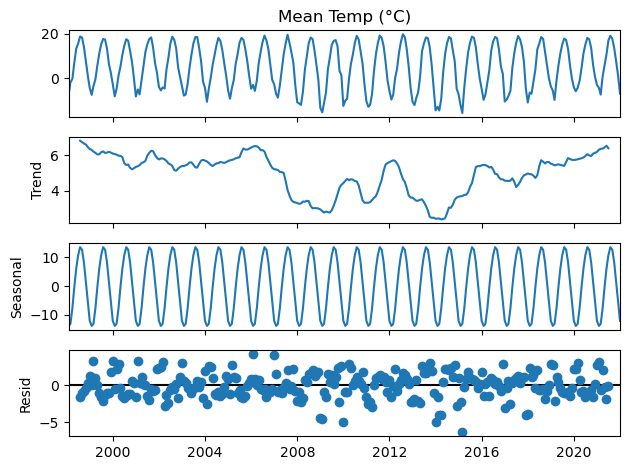

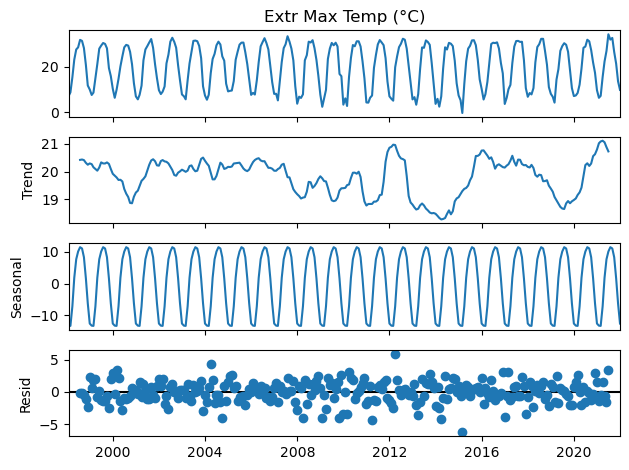

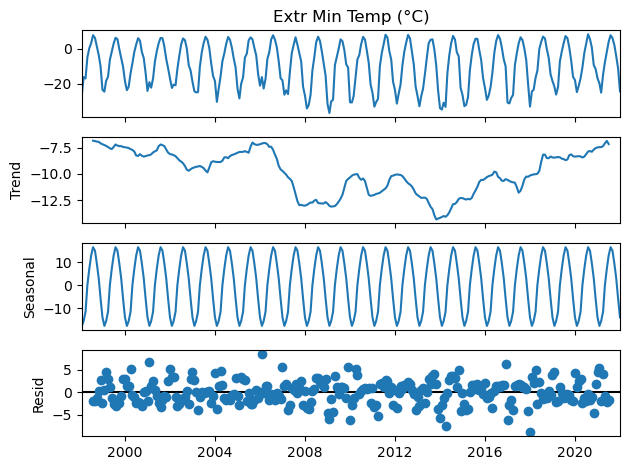

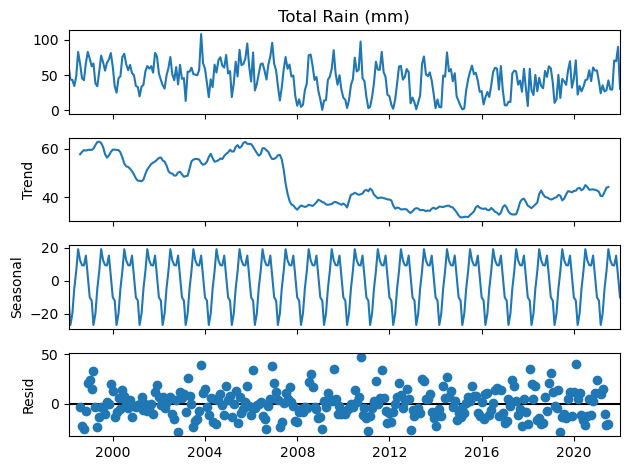

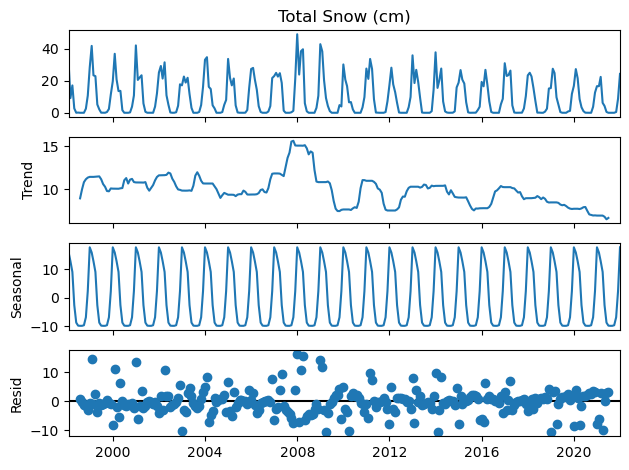

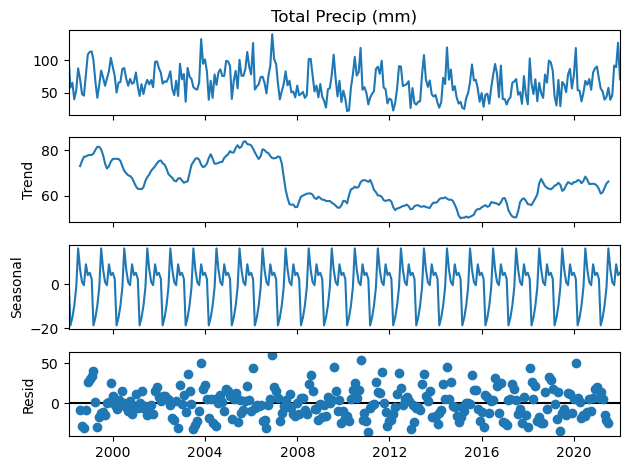

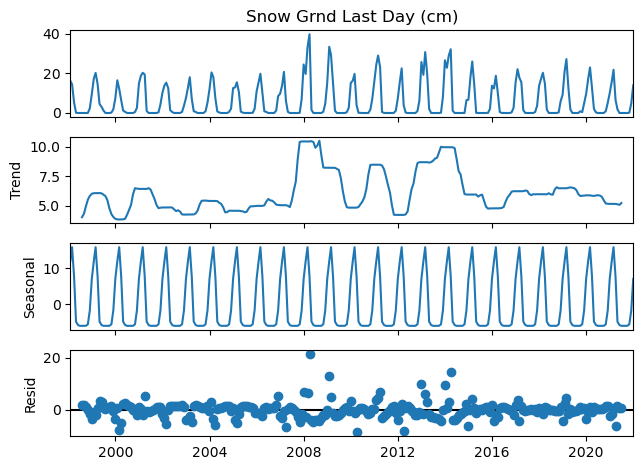

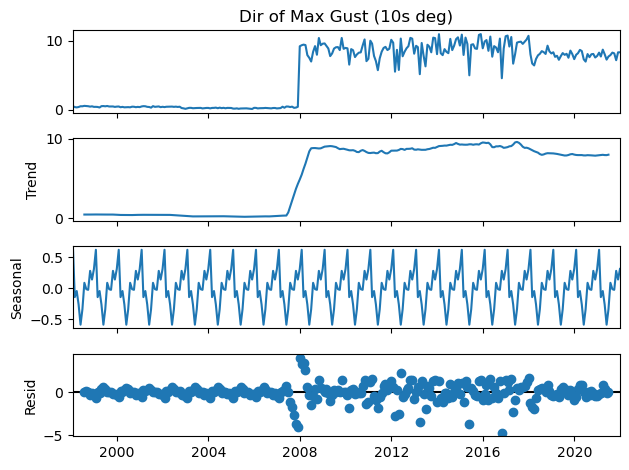

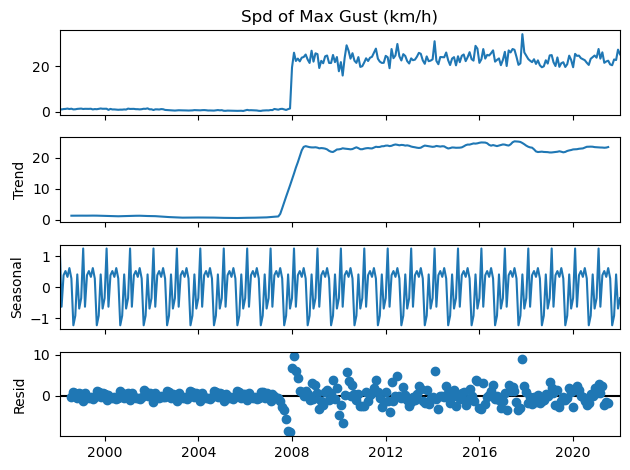

In [16]:
# seasonal decompose to separate different components (trend, seasonality, and residual)

resampled_no_nulls = resampled.dropna()

for col in columns:
    decomp = seasonal_decompose(resampled_no_nulls[col],
                                period = 12)
    decomp.plot()

Dicky-Fuller test

In [17]:
non_stationary_cols = []
stationary_cols = []

for col in columns:
    adfuller_result = adfuller(resampled_no_nulls[col])
    test_statistic, p_value, num_lags, num_obs, critical_values, aic = adfuller_result
    print(adfuller_result)

    # Print ADF test result along with elements
    print(f"ADF Test Result: {col}")
    print(f"Test Statistic: {test_statistic}")
    print(f"P-value: {p_value}")
    print(f"Number of Lags: {num_lags}")
    print(f"Number of Observations: {num_obs}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"  {key}: {value}")
    print(f"Estimated maximized information criterion (aic): {aic}")

    if p_value > 0.05:
        print(f'{col} Data is non-stationary. Needs to be converted to stationary data to use ARIMA.')
        non_stationary_cols.append(col)
    else:
        print(f'{col} Data is stationary. Can proceed with ARIMA or SARIMAX model creation.')
        stationary_cols.append(col)

(-1.221911411690539, 0.6640996740151708, 0, 287, {'1%': -3.453342167806272, '5%': -2.871663828287282, '10%': -2.572164381381345}, 1816.3306793882452)
ADF Test Result: Construction
Test Statistic: -1.221911411690539
P-value: 0.6640996740151708
Number of Lags: 0
Number of Observations: 287
Critical Values:
  1%: -3.453342167806272
  5%: -2.871663828287282
  10%: -2.572164381381345
Estimated maximized information criterion (aic): 1816.3306793882452
Construction Data is non-stationary. Needs to be converted to stationary data to use ARIMA.
(-1.3980798320946208, 0.5831963241614444, 0, 287, {'1%': -3.453342167806272, '5%': -2.871663828287282, '10%': -2.572164381381345}, 1563.8437297214807)
ADF Test Result: Transportation and warehousing
Test Statistic: -1.3980798320946208
P-value: 0.5831963241614444
Number of Lags: 0
Number of Observations: 287
Critical Values:
  1%: -3.453342167806272
  5%: -2.871663828287282
  10%: -2.572164381381345
Estimated maximized information criterion (aic): 1563.84

In [18]:
# Print the list of non-stationary columns
print("\nColumns needing transformation to achieve stationarity:")
print(non_stationary_cols)

# Print the list of non-stationary columns
print("\nColumns that achieve stationarity:")
print(stationary_cols)


Columns needing transformation to achieve stationarity:
['Construction', 'Transportation and warehousing', 'Health care and social assistance', 'Agriculture', 'Wholesale trade Retail trade', 'Population', 'Mean Min Temp (°C)', 'Mean Temp (°C)', 'Extr Min Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']

Columns that achieve stationarity:
['Mean Max Temp (°C)', 'Extr Max Temp (°C)', 'Snow Grnd Last Day (cm)']


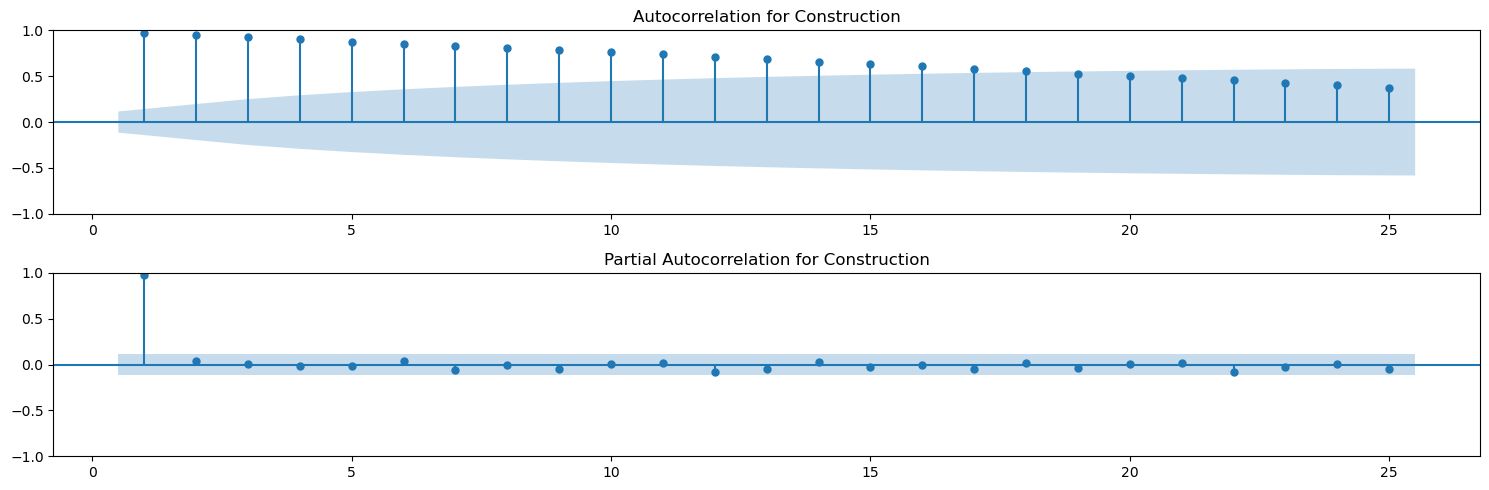

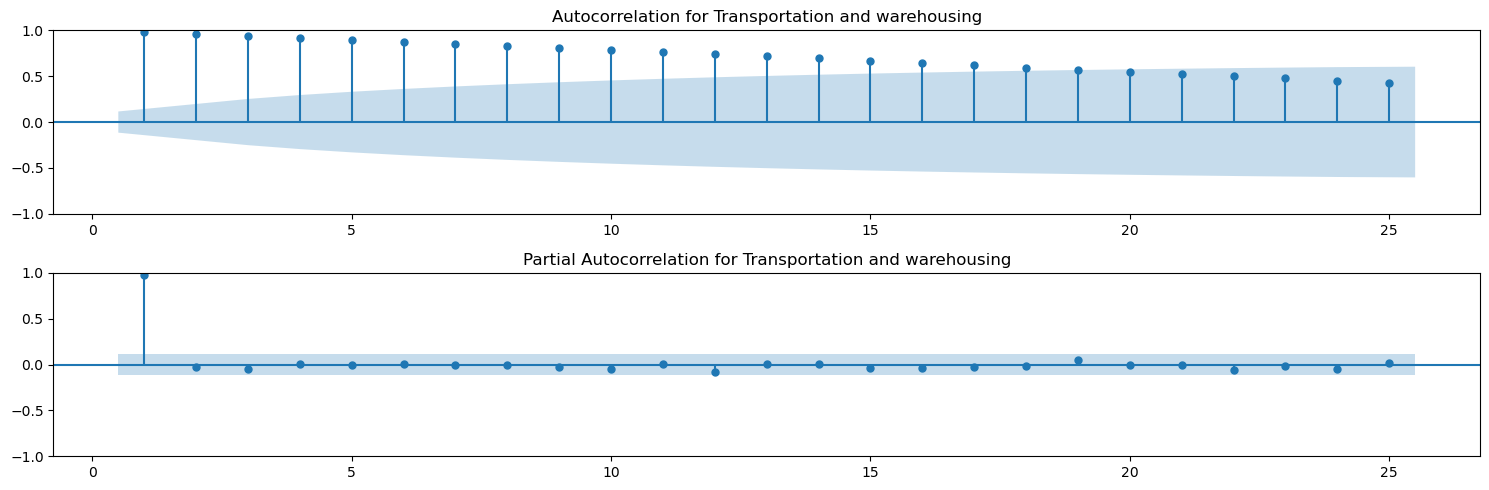

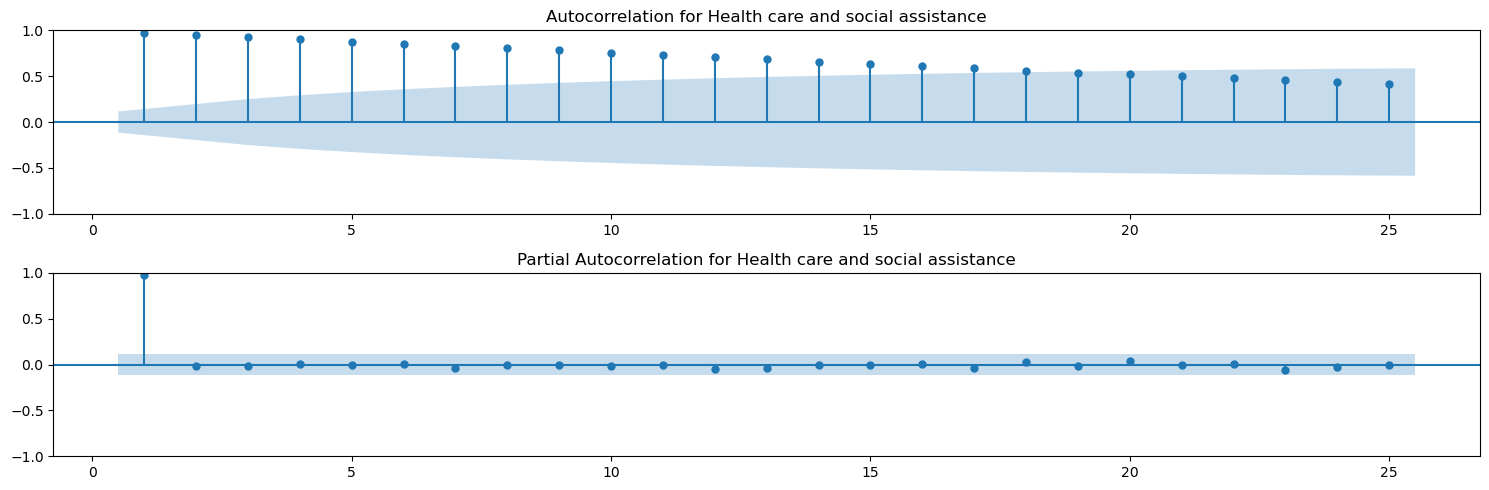

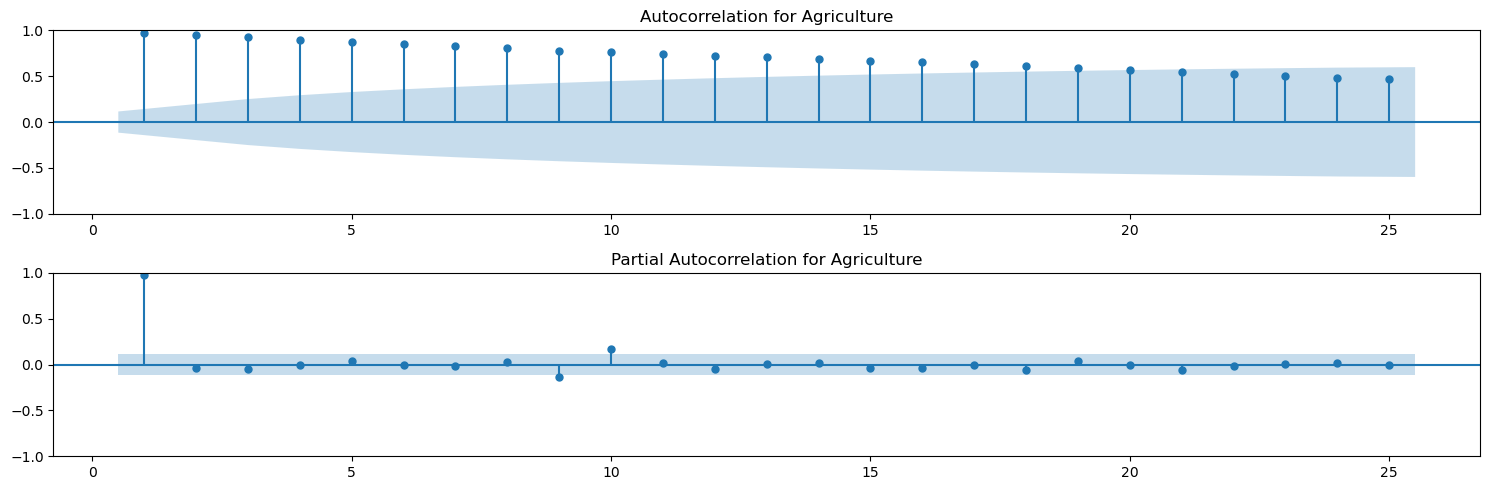

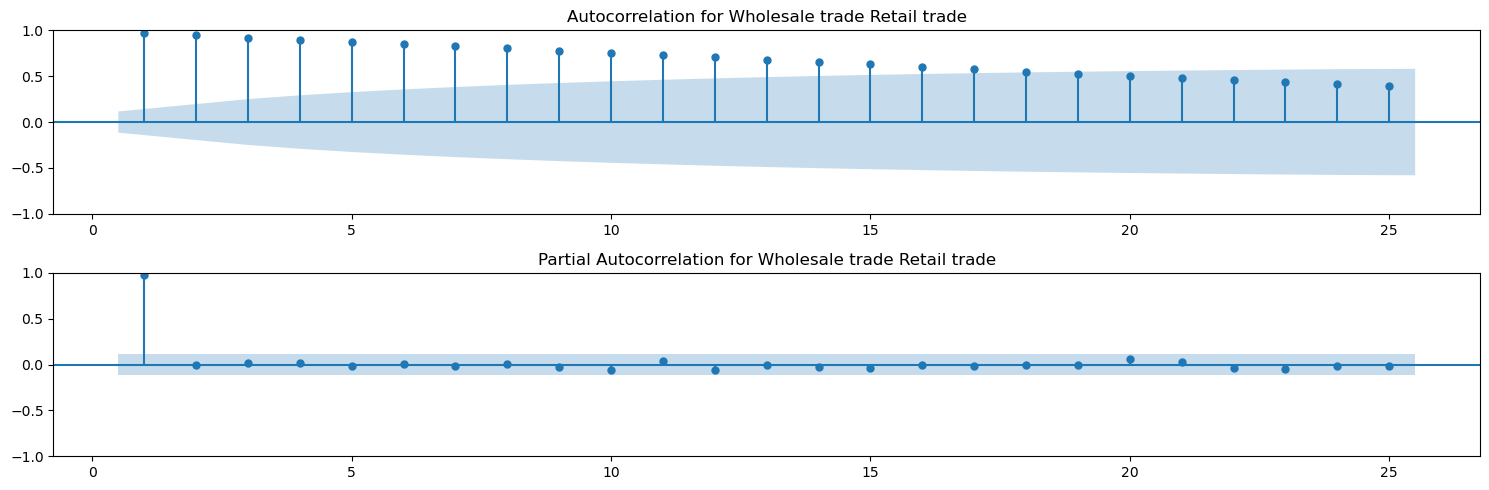

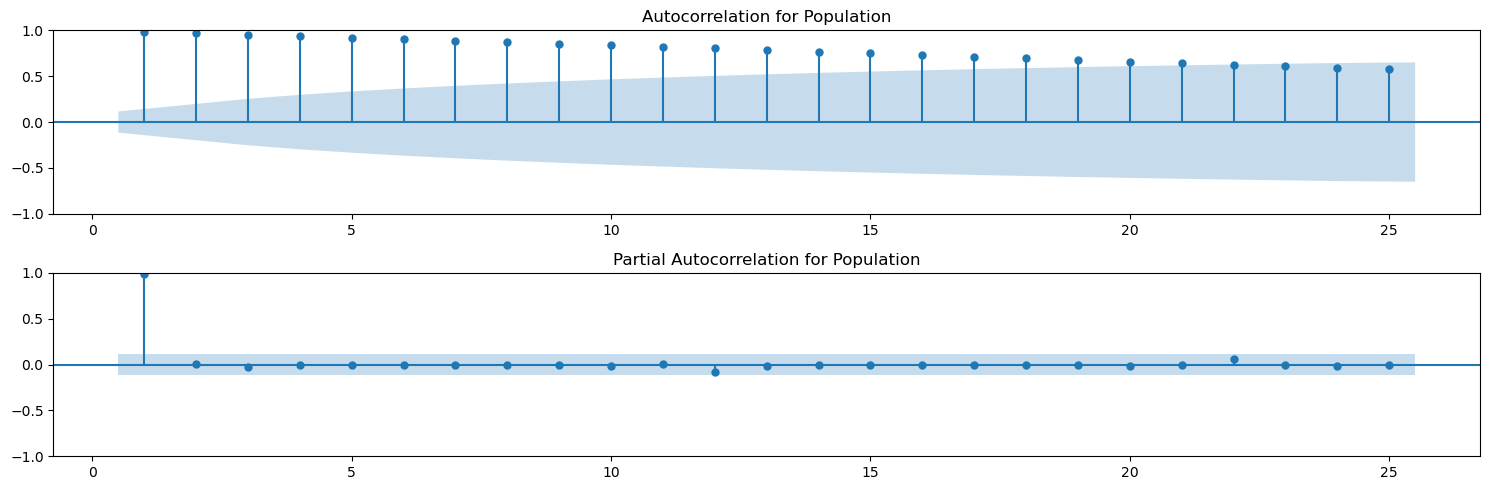

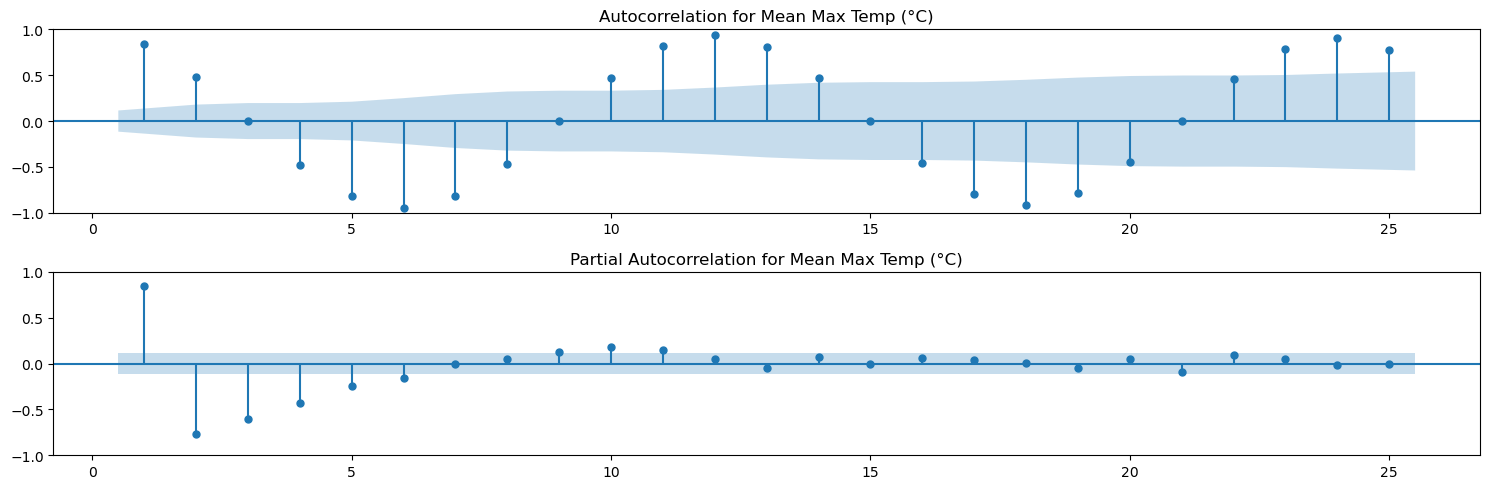

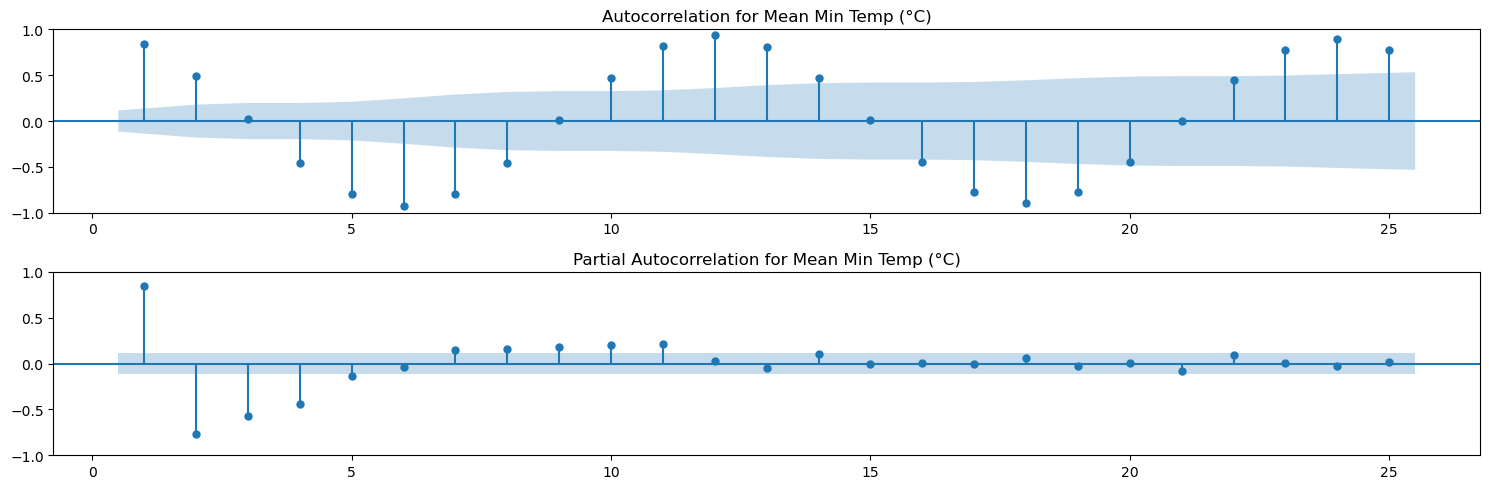

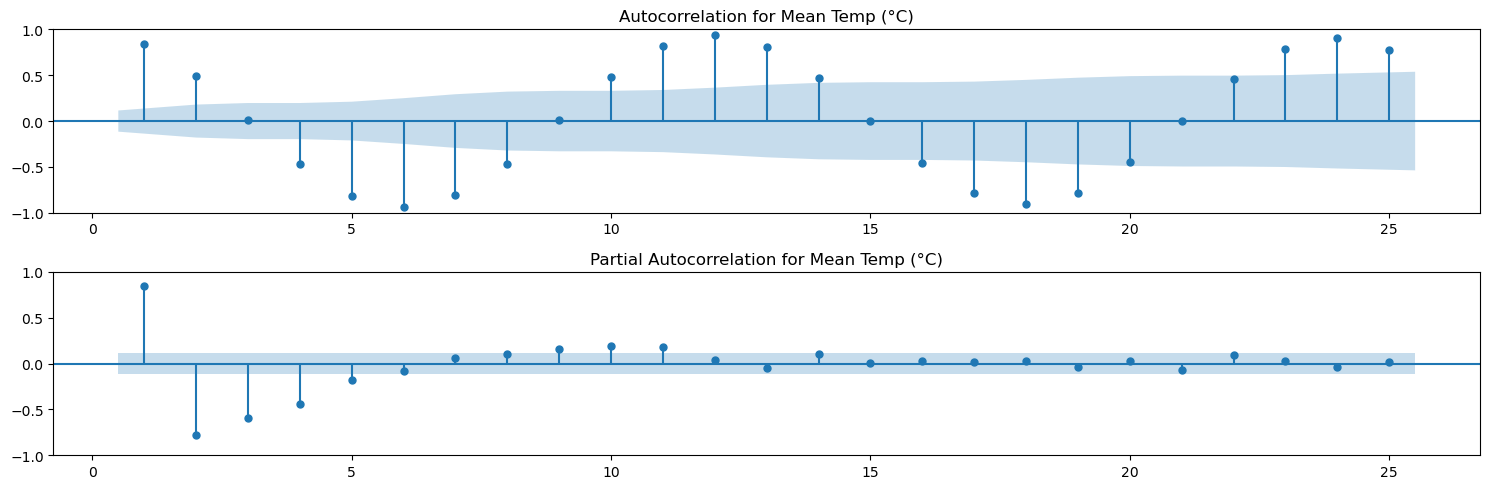

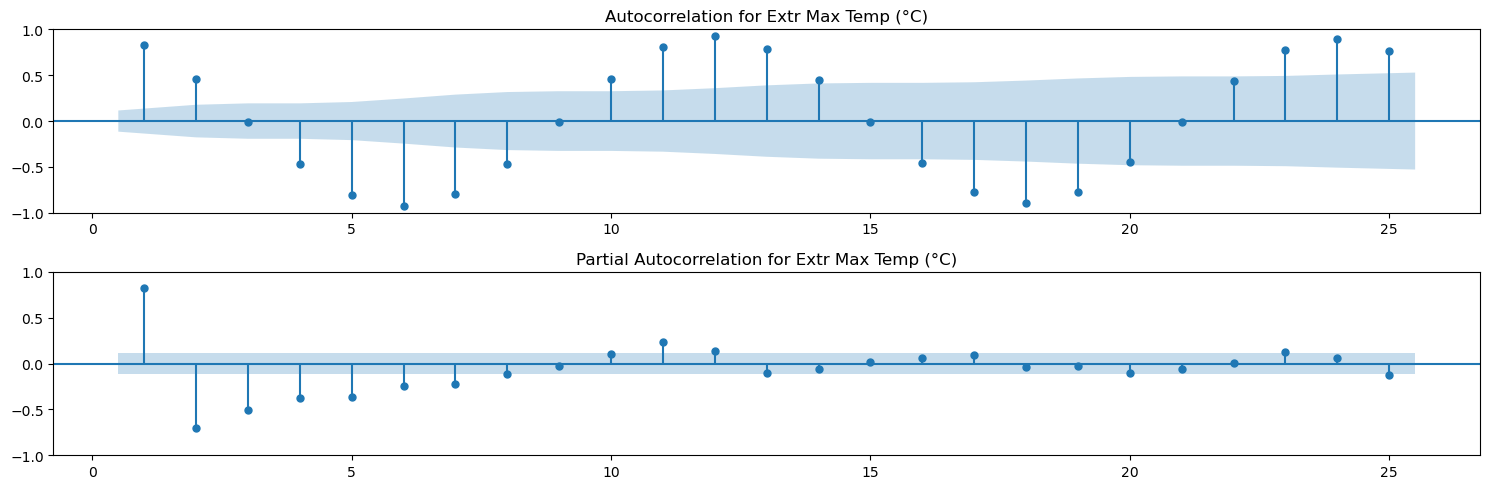

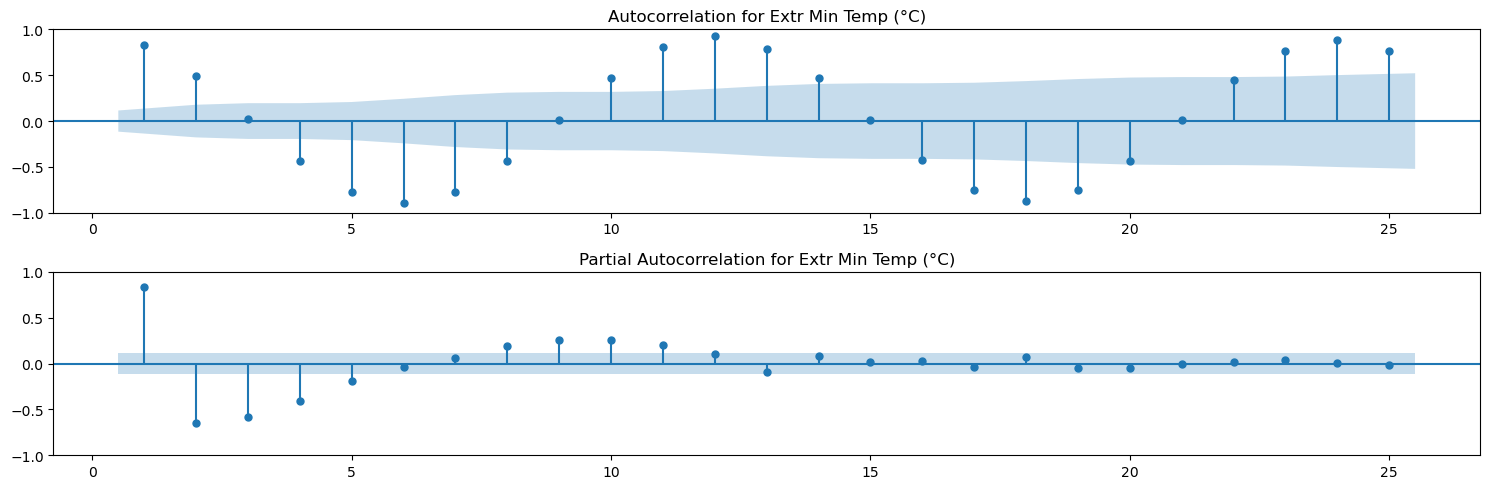

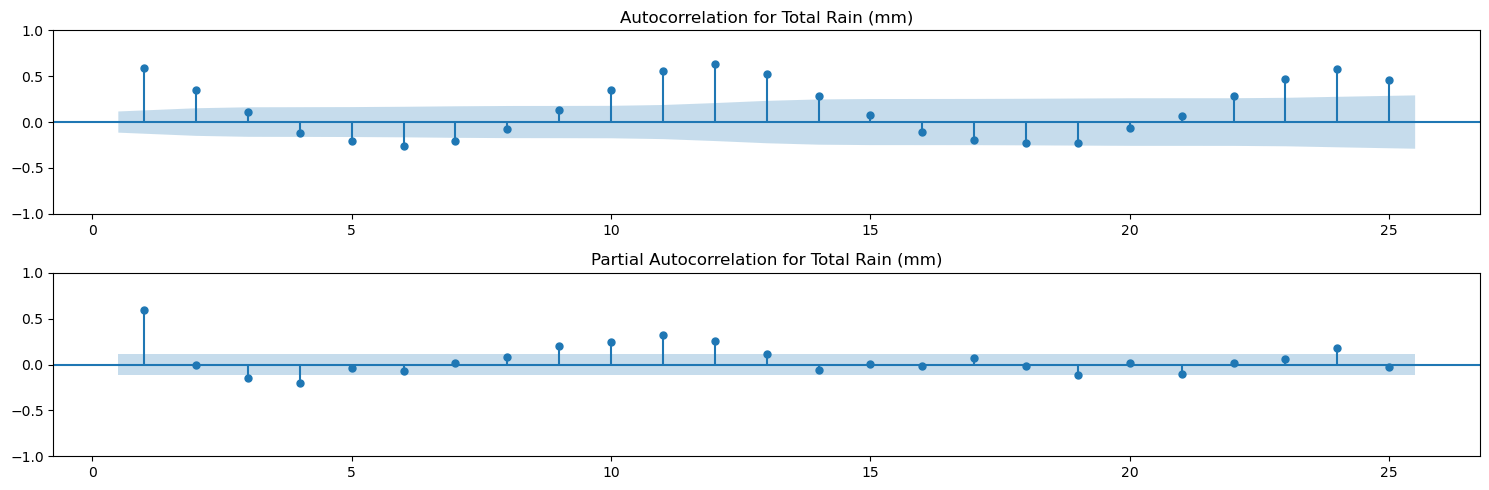

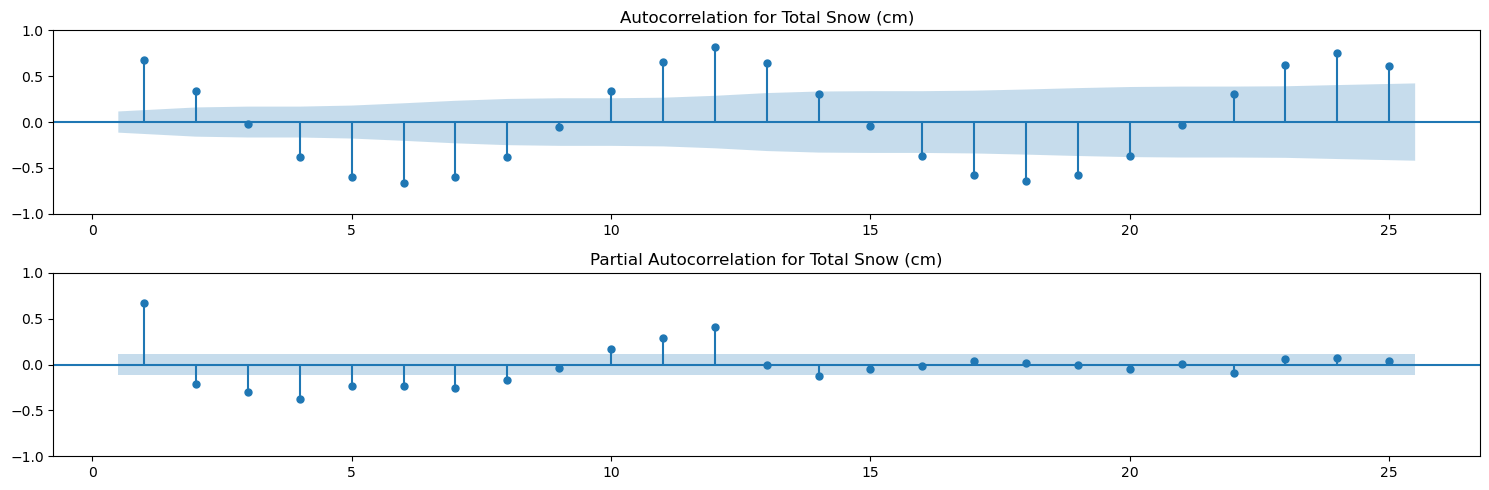

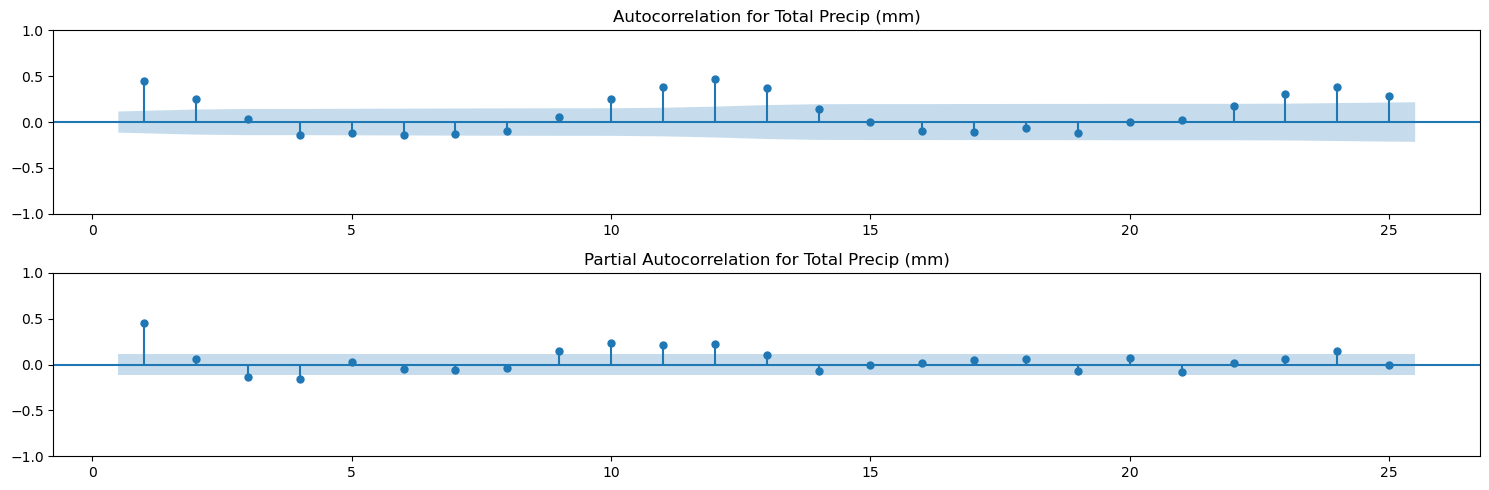

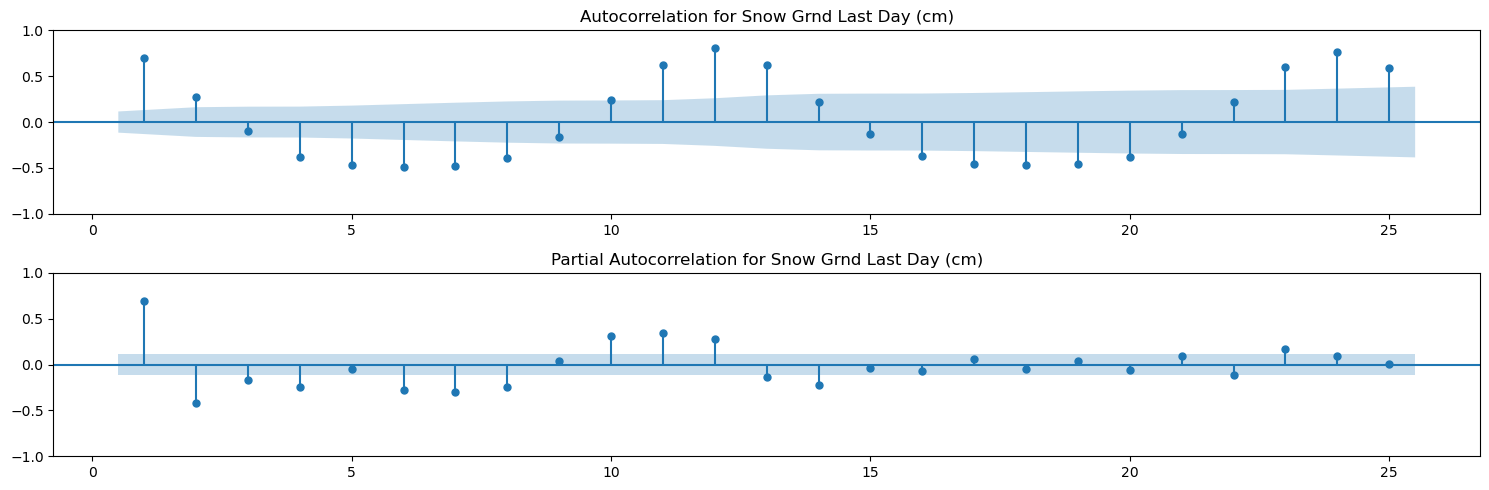

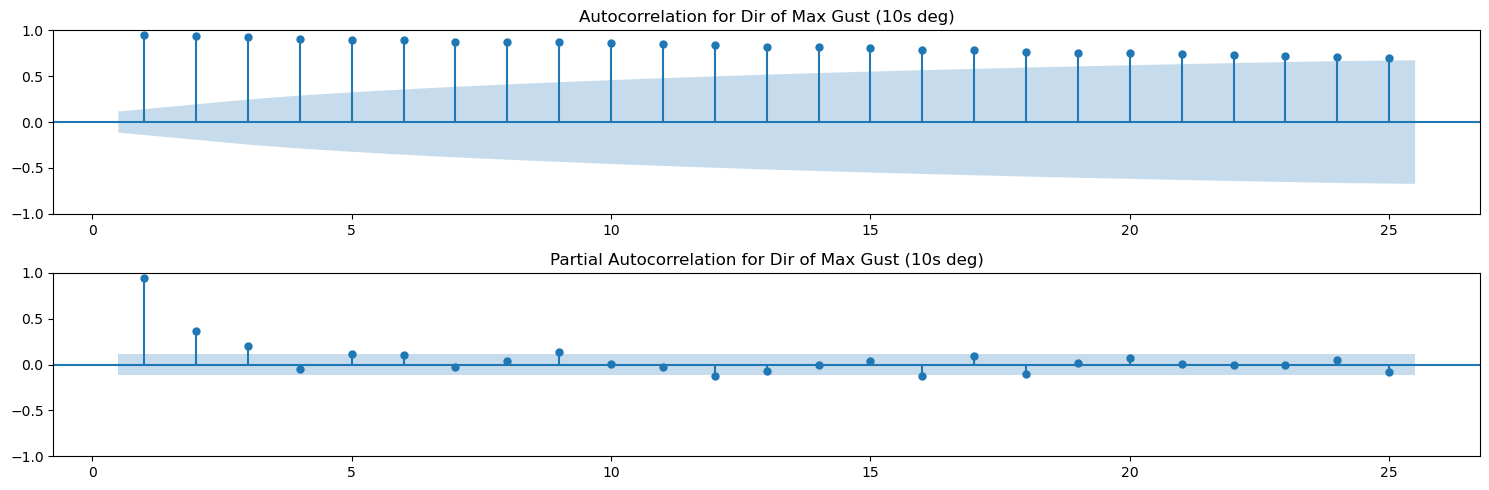

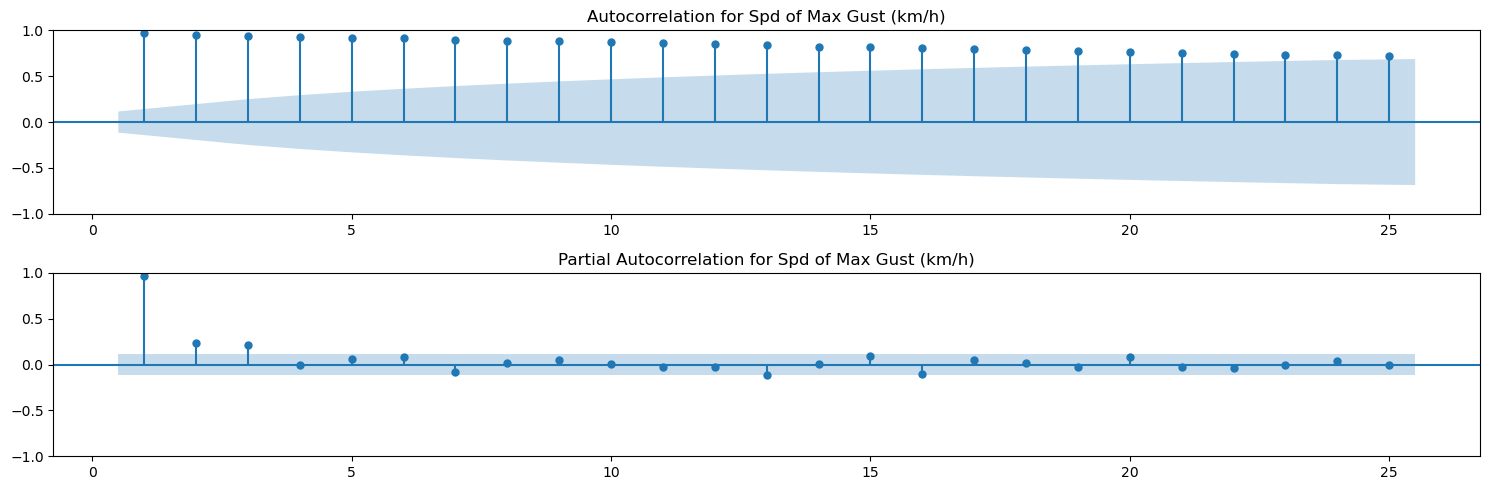

In [19]:
for col in columns:
    # create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15, 5))

    # plot acf
    plot_acf(resampled_no_nulls[col], zero = False, ax = ax1)
    ax1.set_title(f'Autocorrelation for {col}')
    # plot pacf
    plot_pacf(resampled_no_nulls[col],   zero = False, ax = ax2)
    ax2.set_title(f'Partial Autocorrelation for {col}')
    
    plt.tight_layout()
    plt.show()

Split data to train and test dataset for model creation

In [20]:
# split data to train and test
train = resampled.loc[resampled.index <= '2019-01-01']
test = resampled.loc[resampled.index > '2019-01-01']

print(resampled.shape)
print(train.shape)
print(test.shape)
print(test.index.max())

(313, 19)
(252, 19)
(61, 19)
2024-01-31 00:00:00


In [21]:
print(non_stationary_cols)
print(stationary_cols)

['Construction', 'Transportation and warehousing', 'Health care and social assistance', 'Agriculture', 'Wholesale trade Retail trade', 'Population', 'Mean Min Temp (°C)', 'Mean Temp (°C)', 'Extr Min Temp (°C)', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 'Dir of Max Gust (10s deg)', 'Spd of Max Gust (km/h)']
['Mean Max Temp (°C)', 'Extr Max Temp (°C)', 'Snow Grnd Last Day (cm)']


## Time Series Forecasting Model for Stationary Data ##

ARIMA Model for Mean Max Temp (°C) (Stationary)

In [22]:
# Create empty list to store search results
order_aic_bic_arima=[]
col = 'Mean Max Temp (°C)'

for p in range(5):
    for q in range(5):
        try:
            model = sm.tsa.ARIMA(resampled_no_nulls[col], order=(p,0,q), trend='c')
            results = model.fit()
            order_aic_bic_arima.append((col, p, q, results.aic, results.bic))
        except:
            print(col, p, q, None, None)

order_df_arima = pd.DataFrame(order_aic_bic_arima,
                        columns=['Column', 'p', 'q', 'AIC', 'BIC'])

# Sort DataFrame based on AIC and BIC
order_df_arima.sort_values(['AIC', 'BIC'], inplace=True)
print("Sorted by AIC and BIC:")
print(order_df_arima.head(1))


Sorted by AIC and BIC:
                Column  p  q          AIC          BIC
22  Mean Max Temp (°C)  4  2  1212.557691  1241.861375


SARIMAX Model for Mean Max Temp (°C) (Stationary)

In [23]:
# Create empty list to store search results
order_aic_bic_sarimax = []
col = 'Mean Max Temp (°C)'

# Loop over seasonal parameters (P, D, Q, s)
for P in range(3):  
    for D in range(3):  
        for Q in range(3): 
            # Loop over non-seasonal parameters (p, d, q)
            for p in range(3):
                for q in range(3): 
                    try:
                        # Create and fit SARIMAX(p, d, q)(P, D, Q, s) model
                        model = sm.tsa.SARIMAX(resampled_no_nulls[col],  
                                               order=(p, 0, q),
                                                seasonal_order=(P, D, Q, 12), 
                                                trend='c')
                        results = model.fit()

                        # Append order and results tuple
                        order_aic_bic_sarimax.append((col, p, q, P, D, Q, results.aic, results.bic))
                    except Exception as e:
                        print(f'Error: {e}')
                        
# Construct DataFrame from order_aic_bic    
order_df_sarimax = pd.DataFrame(order_aic_bic_sarimax,
                    columns=['Column', 'p', 'q', 'P', 'D', 'Q', 'AIC', 'BIC'])

# Sort DataFrame based on AIC and BIC
order_df_sarimax.sort_values(['AIC', 'BIC'], inplace=True)
print("Sorted by AIC and BIC:")
print(order_df_sarimax.head(1))

Error: LU decomposition error.
Sorted by AIC and BIC:
                 Column  p  q  P  D  Q        AIC        BIC
177  Mean Max Temp (°C)  2  0  2  0  1  58.007389  83.648112


In [24]:
### ARIMA for Mean Max Temp (°C) ###

# Get the optimal parameters (p and q) for the current column
p = order_df_arima.loc[order_df_arima['Column'] == col, 'p'].iloc[0]
q = order_df_arima.loc[order_df_arima['Column'] == col, 'q'].iloc[0]

# Instantiate the model
model_arima = sm.tsa.ARIMA(train['Mean Max Temp (°C)'], order=(p, 0, q)) # order=(p,d,q)

# Fit the model
results_train_arima = model_arima.fit()

# Print model fit summary
print(f"Summary for column '{col}':")
print(results_train_arima.summary())



### SARIMAX for Mean Max Temp (°C) ###

# Get the optimal parameters (p and q) for the current column
p = order_df_sarimax.loc[order_df_sarimax['Column'] == col, 'p'].iloc[0]
q = order_df_sarimax.loc[order_df_sarimax['Column'] == col, 'q'].iloc[0]
P = order_df_sarimax.loc[order_df_sarimax['Column'] == col, 'P'].iloc[0]
D = order_df_sarimax.loc[order_df_sarimax['Column'] == col, 'D'].iloc[0]
Q = order_df_sarimax.loc[order_df_sarimax['Column'] == col, 'Q'].iloc[0]

# Instantiate the model
model_sarimax = sm.tsa.SARIMAX(train['Mean Max Temp (°C)'], order=(p, 0, q),
                            seasonal_order = (P, D, Q, 12))

# # Fit the model
results_train_sarimax = model_sarimax.fit()

# Print model fit summary
print(results_train_sarimax.summary())


Summary for column 'Mean Max Temp (°C)':
                               SARIMAX Results                                
Dep. Variable:     Mean Max Temp (°C)   No. Observations:                  252
Model:                 ARIMA(4, 0, 2)   Log Likelihood                -529.488
Date:                Thu, 11 Apr 2024   AIC                           1074.975
Time:                        21:09:40   BIC                           1103.210
Sample:                    01-31-1998   HQIC                          1086.336
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.2862      0.245     42.058      0.000       9.807      10.766
ar.L1          1.9878      0.065     30.496      0.000       1.860       2.116
ar.L2      

In [25]:
predictions = {}  # Initialize an empty dictionary to store predictions for each column

# Make predictions using ARIMA
arima_predictions = results_train_arima.predict(start=test['Mean Max Temp (°C)'].index[0], 
                                                end=test['Mean Max Temp (°C)'].index[-1], 
                                                typ='levels')

predictions[col] = {'ARIMA': arima_predictions}

# Make predictions using SARIMAX (assuming you have the SARIMAX results stored)
sarimax_predictions = results_train_sarimax.predict(start=test['Mean Max Temp (°C)'].index[0],
                                                    end=test['Mean Max Temp (°C)'].index[-1], 
                                                    typ='levels')
predictions[col]['SARIMAX'] = sarimax_predictions

# Print predictions
print(f"Predictions for column '{col}':")
print("ARIMA:", arima_predictions.head(5))
print("SARIMAX:", sarimax_predictions.head(5))


Predictions for column 'Mean Max Temp (°C)':
ARIMA: 2019-01-31    -4.545397
2019-02-28    -2.735880
2019-03-31     2.769799
2019-04-30    10.546686
2019-05-31    18.334749
Freq: M, Name: predicted_mean, dtype: float64
SARIMAX: 2019-01-31    -3.109826
2019-02-28    -2.340579
2019-03-31     2.472089
2019-04-30     9.884251
2019-05-31    18.741754
Freq: M, Name: predicted_mean, dtype: float64


In [26]:
# to calculate MAE< MAPE and RSME
arima_MAE = mean_absolute_error(test['Mean Max Temp (°C)'], arima_predictions)
print(f'Arima_MAE:', arima_MAE)
arima_MAPE = mean_absolute_percentage_error(test['Mean Max Temp (°C)'], arima_predictions)
print(f'Arima_MAPE:', arima_MAPE)
arima_RMSE = np.sqrt(mean_squared_error(test['Mean Max Temp (°C)'], arima_predictions))
print(f'Arima_RMSE:', arima_RMSE)

sarimax_MAE = mean_absolute_error(test['Mean Max Temp (°C)'], sarimax_predictions)
print(f'Sarimax_MAE:', sarimax_MAE)
sarimax_MAPE = mean_absolute_percentage_error(test['Mean Max Temp (°C)'], sarimax_predictions)
print(f'Sarimax_MAPE:', sarimax_MAPE)
sarimax_RMSE = np.sqrt(mean_squared_error(test['Mean Max Temp (°C)'], sarimax_predictions))
print(f'Sarimax_RMSE:', sarimax_RMSE)

Arima_MAE: 1.843469195060381
Arima_MAPE: 0.982409910728431
Arima_RMSE: 2.2865242346904107
Sarimax_MAE: 1.619049129866542
Sarimax_MAPE: 1.029308519134981
Sarimax_RMSE: 2.1147324871195057


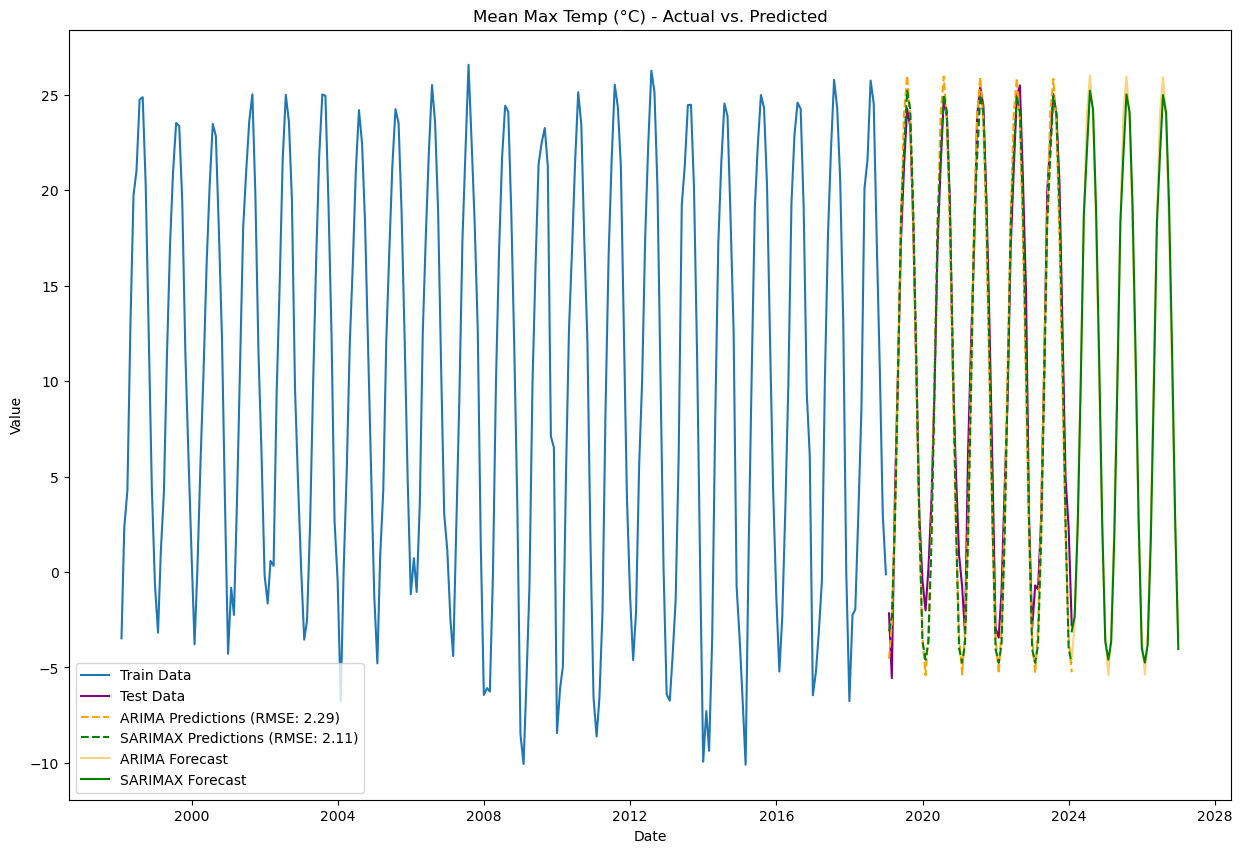

In [27]:
# Extend the time index to include future dates
future_dates = pd.date_range(start=test.index[-1], periods=36, freq='M')

# Get ARIMA forecast for future dates
arima_forecast = results_train_arima.get_forecast(steps=36)

# Get SARIMAX forecast for future dates
sarimax_forecast = results_train_sarimax.get_forecast(steps=36)

# Plot actual vs. predicted values
plt.figure(figsize=(15, 10))
plt.plot(train['Mean Max Temp (°C)'].index, train['Mean Max Temp (°C)'], label='Train Data')
plt.plot(test['Mean Max Temp (°C)'].index, test['Mean Max Temp (°C)'], label='Test Data', color='purple')
plt.plot(test['Mean Max Temp (°C)'].index, arima_predictions, 
         label=f'ARIMA Predictions (RMSE: {arima_RMSE:.2f})',
         linestyle='--', alpha=1.0, color='orange')
plt.plot(test['Mean Max Temp (°C)'].index, 
         sarimax_predictions, label=f'SARIMAX Predictions (RMSE: {sarimax_RMSE:.2f})', 
         linestyle='--', alpha=1.0, color='green')
plt.plot(future_dates, arima_forecast.predicted_mean, 
         label='ARIMA Forecast', alpha=.5, color='orange')
plt.plot(future_dates, sarimax_forecast.predicted_mean, 
         label='SARIMAX Forecast', color='green')
plt.title('Mean Max Temp (°C) - Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


ARIMA Model for Extr Max Temp (°C) (Stationary)

In [31]:
# Create empty list to store search results
order_aic_bic_arima=[]
col = 'Extr Max Temp (°C)'

for p in range(5):
    for q in range(5):
        try:
            model = sm.tsa.ARIMA(resampled_no_nulls[col], order=(p,0,q), trend='c')
            results = model.fit()
            order_aic_bic_arima.append((col, p, q, results.aic, results.bic))
        except:
            print(col, p, q, None, None)

order_df_arima = pd.DataFrame(order_aic_bic_arima,
                        columns=['Column', 'p', 'q', 'AIC', 'BIC'])

# Sort DataFrame based on AIC and BIC
order_df_arima.sort_values(['AIC', 'BIC'], inplace=True)
print("Sorted by AIC and BIC:")
print(order_df_arima.head(1))


Sorted by AIC and BIC:
                Column  p  q          AIC          BIC
13  Extr Max Temp (°C)  2  3  1287.945402  1313.586126


SARIMAX Model for Extr Max Temp (°C) (Stationary)

In [33]:
# Create empty list to store search results
order_aic_bic_sarimax = []
col = 'Extr Max Temp (°C)'

# Loop over seasonal parameters (P, D, Q, s)
for P in range(3):  
    for D in range(3):  
        for Q in range(3): 
            # Loop over non-seasonal parameters (p, d, q)
            for p in range(3):
                for q in range(3): 
                    try:
                        # Create and fit SARIMAX(p, d, q)(P, D, Q, s) model
                        model = sm.tsa.SARIMAX(resampled_no_nulls[col],  
                                               order=(p, 0, q),
                                                seasonal_order=(P, D, Q, 12), 
                                                trend='c')
                        results = model.fit()

                        # Append order and results tuple
                        order_aic_bic_sarimax.append((col, p, q, P, D, Q, results.aic, results.bic))
                    except Exception as e:
                        print(f'Error: {e}')
                        
# Construct DataFrame from order_aic_bic    
order_df_sarimax = pd.DataFrame(order_aic_bic_sarimax,
                    columns=['Column', 'p', 'q', 'P', 'D', 'Q', 'AIC', 'BIC'])

# Sort DataFrame based on AIC and BIC
order_df_sarimax.sort_values(['AIC', 'BIC'], inplace=True)
print("Sorted by AIC and BIC:")
print(order_df_sarimax.head(1))

Sorted by AIC and BIC:
                Column  p  q  P  D  Q          AIC          BIC
40  Extr Max Temp (°C)  1  1  0  1  1  1156.188138  1174.290142


In [34]:
### ARIMA for Mean Max Temp (°C) ###

# Get the optimal parameters (p and q) for the current column
p = order_df_arima.loc[order_df_arima['Column'] == col, 'p'].iloc[0]
q = order_df_arima.loc[order_df_arima['Column'] == col, 'q'].iloc[0]

# Instantiate the model
model_arima = sm.tsa.ARIMA(train['Extr Max Temp (°C)'], order=(p, 0, q)) # order=(p,d,q)

# Fit the model
results_train_arima = model_arima.fit()

# Print model fit summary
print(f"Summary for column '{col}':")
print(results_train_arima.summary())



### SARIMAX for Mean Max Temp (°C) ###

# Get the optimal parameters (p and q) for the current column
p = order_df_sarimax.loc[order_df_sarimax['Column'] == col, 'p'].iloc[0]
q = order_df_sarimax.loc[order_df_sarimax['Column'] == col, 'q'].iloc[0]
P = order_df_sarimax.loc[order_df_sarimax['Column'] == col, 'P'].iloc[0]
D = order_df_sarimax.loc[order_df_sarimax['Column'] == col, 'D'].iloc[0]
Q = order_df_sarimax.loc[order_df_sarimax['Column'] == col, 'Q'].iloc[0]

# Instantiate the model
model_sarimax = sm.tsa.SARIMAX(train['Extr Max Temp (°C)'], order=(p, 0, q),
                            seasonal_order = (P, D, Q, 12))

# # Fit the model
results_train_sarimax = model_sarimax.fit()

# Print model fit summary
print(results_train_sarimax.summary())


Summary for column 'Extr Max Temp (°C)':
                               SARIMAX Results                                
Dep. Variable:     Extr Max Temp (°C)   No. Observations:                  252
Model:                 ARIMA(2, 0, 3)   Log Likelihood                -562.284
Date:                Fri, 12 Apr 2024   AIC                           1138.569
Time:                        20:53:06   BIC                           1163.275
Sample:                    01-31-1998   HQIC                          1148.510
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.8077      0.186    106.363      0.000      19.443      20.173
ar.L1          1.7323      0.001   2092.758      0.000       1.731       1.734
ar.L2      

In [35]:
predictions = {}  # Initialize an empty dictionary to store predictions for each column

# Make predictions using ARIMA
arima_predictions = results_train_arima.predict(start=test['Extr Max Temp (°C)'].index[0], 
                                                end=test['Extr Max Temp (°C)'].index[-1], 
                                                typ='levels')

predictions[col] = {'ARIMA': arima_predictions}

# Make predictions using SARIMAX (assuming you have the SARIMAX results stored)
sarimax_predictions = results_train_sarimax.predict(start=test['Extr Max Temp (°C)'].index[0],
                                                    end=test['Extr Max Temp (°C)'].index[-1], 
                                                    typ='levels')
predictions[col]['SARIMAX'] = sarimax_predictions

# Print predictions
print(f"Predictions for column '{col}':")
print("ARIMA:", arima_predictions.head(5))
print("SARIMAX:", sarimax_predictions.head(5))


Predictions for column 'Extr Max Temp (°C)':
ARIMA: 2019-01-31     6.216902
2019-02-28     7.597679
2019-03-31    12.393629
2019-04-30    19.173905
2019-05-31    26.123490
Freq: M, Name: predicted_mean, dtype: float64
SARIMAX: 2019-01-31     6.477854
2019-02-28     6.159598
2019-03-31    11.772060
2019-04-30    21.707590
2019-05-31    28.322638
Freq: M, Name: predicted_mean, dtype: float64


In [36]:
# to calculate MAE< MAPE and RSME
arima_MAE = mean_absolute_error(test['Extr Max Temp (°C)'], arima_predictions)
print(f'Arima_MAE:', arima_MAE)
arima_MAPE = mean_absolute_percentage_error(test['Extr Max Temp (°C)'], arima_predictions)
print(f'Arima_MAPE:', arima_MAPE)
arima_RMSE = np.sqrt(mean_squared_error(test['Extr Max Temp (°C)'], arima_predictions))
print(f'Arima_RMSE:', arima_RMSE)

sarimax_MAE = mean_absolute_error(test['Extr Max Temp (°C)'], sarimax_predictions)
print(f'Sarimax_MAE:', sarimax_MAE)
sarimax_MAPE = mean_absolute_percentage_error(test['Extr Max Temp (°C)'], sarimax_predictions)
print(f'Sarimax_MAPE:', sarimax_MAPE)
sarimax_RMSE = np.sqrt(mean_squared_error(test['Extr Max Temp (°C)'], sarimax_predictions))
print(f'Sarimax_RMSE:', sarimax_RMSE)

Arima_MAE: 1.5356189890593144
Arima_MAPE: 0.09928794350156019
Arima_RMSE: 1.851232906857312
Sarimax_MAE: 1.4238273675953428
Sarimax_MAPE: 0.09997644298848372
Sarimax_RMSE: 1.8519259225843663


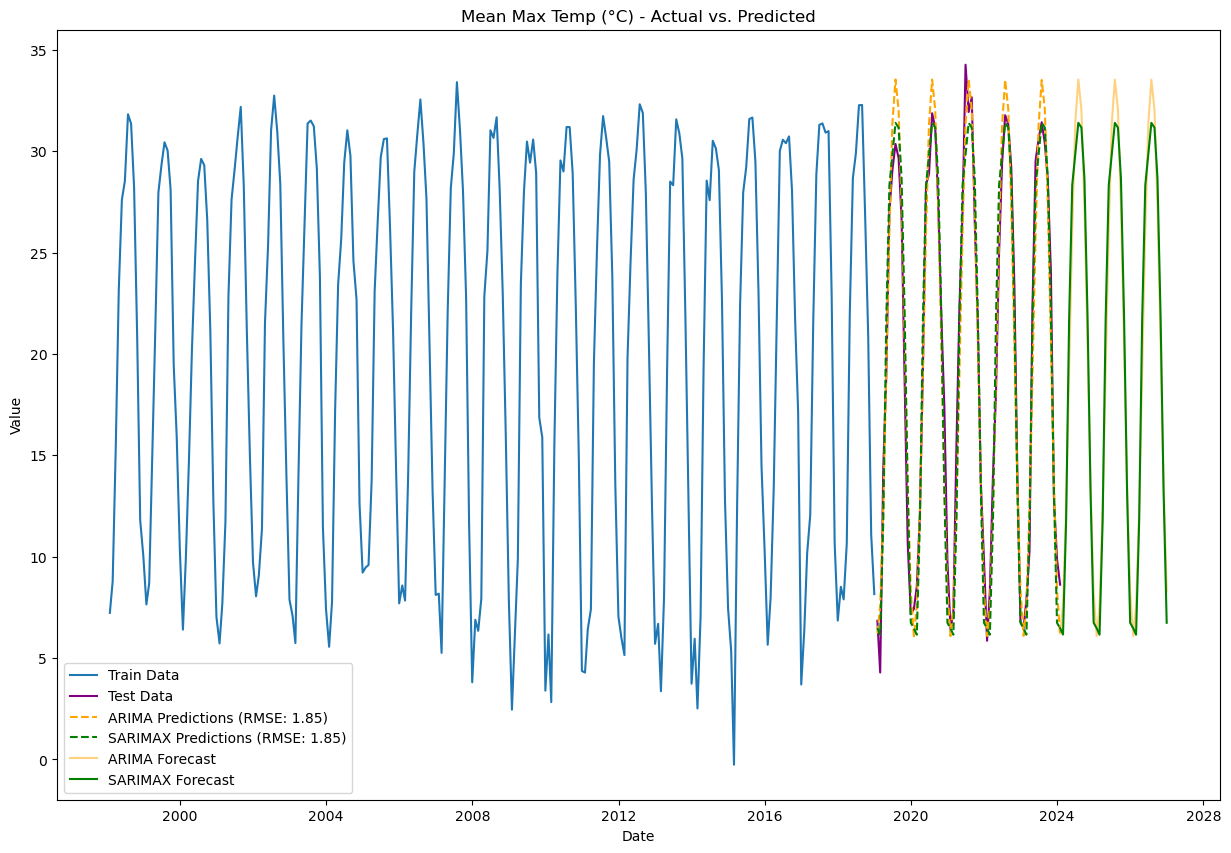

In [37]:
# Extend the time index to include future dates
future_dates = pd.date_range(start=test.index[-1], periods=36, freq='M')

# Get ARIMA forecast for future dates
arima_forecast = results_train_arima.get_forecast(steps=36)

# Get SARIMAX forecast for future dates
sarimax_forecast = results_train_sarimax.get_forecast(steps=36)

# Plot actual vs. predicted values
plt.figure(figsize=(15, 10))
plt.plot(train['Mean Max Temp (°C)'].index, train['Extr Max Temp (°C)'], label='Train Data')
plt.plot(test['Mean Max Temp (°C)'].index, test['Extr Max Temp (°C)'], label='Test Data', color='purple')
plt.plot(test['Mean Max Temp (°C)'].index, arima_predictions, 
         label=f'ARIMA Predictions (RMSE: {arima_RMSE:.2f})',
         linestyle='--', alpha=1.0, color='orange')
plt.plot(test['Mean Max Temp (°C)'].index, 
         sarimax_predictions, label=f'SARIMAX Predictions (RMSE: {sarimax_RMSE:.2f})', 
         linestyle='--', alpha=1.0, color='green')
plt.plot(future_dates, arima_forecast.predicted_mean, 
         label='ARIMA Forecast', alpha=.5, color='orange')
plt.plot(future_dates, sarimax_forecast.predicted_mean, 
         label='SARIMAX Forecast', color='green')
plt.title('Mean Max Temp (°C) - Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


ARIMA Model for Snow Grnd Last Day (cm) (Stationary)

In [38]:
# Create empty list to store search results
order_aic_bic_arima=[]
col = 'Snow Grnd Last Day (cm)'

for p in range(5):
    for q in range(5):
        try:
            model = sm.tsa.ARIMA(resampled_no_nulls[col], order=(p,0,q), trend='c')
            results = model.fit()
            order_aic_bic_arima.append((col, p, q, results.aic, results.bic))
        except:
            print(col, p, q, None, None)

order_df_arima = pd.DataFrame(order_aic_bic_arima,
                        columns=['Column', 'p', 'q', 'AIC', 'BIC'])

# Sort DataFrame based on AIC and BIC
order_df_arima.sort_values(['AIC', 'BIC'], inplace=True)
print("Sorted by AIC and BIC:")
print(order_df_arima.head(1))


Sorted by AIC and BIC:
                     Column  p  q          AIC          BIC
13  Snow Grnd Last Day (cm)  2  3  1708.890258  1734.530981


SARIMAX Model for Snow Grnd Last Day (cm) (Stationary)

In [39]:
# Create empty list to store search results
order_aic_bic_sarimax = []
col = 'Snow Grnd Last Day (cm)'

# Loop over seasonal parameters (P, D, Q, s)
for P in range(3):  
    for D in range(3):  
        for Q in range(3): 
            # Loop over non-seasonal parameters (p, d, q)
            for p in range(3):
                for q in range(3): 
                    try:
                        # Create and fit SARIMAX(p, d, q)(P, D, Q, s) model
                        model = sm.tsa.SARIMAX(resampled_no_nulls[col],  
                                               order=(p, 0, q),
                                                seasonal_order=(P, D, Q, 12), 
                                                trend='c')
                        results = model.fit()

                        # Append order and results tuple
                        order_aic_bic_sarimax.append((col, p, q, P, D, Q, results.aic, results.bic))
                    except Exception as e:
                        print(f'Error: {e}')
                        
# Construct DataFrame from order_aic_bic    
order_df_sarimax = pd.DataFrame(order_aic_bic_sarimax,
                    columns=['Column', 'p', 'q', 'P', 'D', 'Q', 'AIC', 'BIC'])

# Sort DataFrame based on AIC and BIC
order_df_sarimax.sort_values(['AIC', 'BIC'], inplace=True)
print("Sorted by AIC and BIC:")
print(order_df_sarimax.head(1))

In [ ]:
### ARIMA for Mean Max Temp (°C) ###

# Get the optimal parameters (p and q) for the current column
p = order_df_arima.loc[order_df_arima['Column'] == col, 'p'].iloc[0]
q = order_df_arima.loc[order_df_arima['Column'] == col, 'q'].iloc[0]

# Instantiate the model
model_arima = sm.tsa.ARIMA(train['Mean Max Temp (°C)'], order=(p, 0, q)) # order=(p,d,q)

# Fit the model
results_train_arima = model_arima.fit()

# Print model fit summary
print(f"Summary for column '{col}':")
print(results_train_arima.summary())



### SARIMAX for Mean Max Temp (°C) ###

# Get the optimal parameters (p and q) for the current column
p = order_df_sarimax.loc[order_df_sarimax['Column'] == col, 'p'].iloc[0]
q = order_df_sarimax.loc[order_df_sarimax['Column'] == col, 'q'].iloc[0]
P = order_df_sarimax.loc[order_df_sarimax['Column'] == col, 'P'].iloc[0]
D = order_df_sarimax.loc[order_df_sarimax['Column'] == col, 'D'].iloc[0]
Q = order_df_sarimax.loc[order_df_sarimax['Column'] == col, 'Q'].iloc[0]

# Instantiate the model
model_sarimax = sm.tsa.SARIMAX(train['Mean Max Temp (°C)'], order=(p, 0, q),
                            seasonal_order = (P, D, Q, 12))

# # Fit the model
results_train_sarimax = model_sarimax.fit()

# Print model fit summary
print(results_train_sarimax.summary())


In [ ]:
predictions = {}  # Initialize an empty dictionary to store predictions for each column

# Make predictions using ARIMA
arima_predictions = results_train_arima.predict(start=test[col].index[0], 
                                                end=test[col].index[-1], 
                                                typ='levels')

predictions[col] = {'ARIMA': arima_predictions}

# Make predictions using SARIMAX (assuming you have the SARIMAX results stored)
sarimax_predictions = results_train_sarimax.predict(start=test[col].index[0],
                                                    end=test[col].index[-1], 
                                                    typ='levels')
predictions[col]['SARIMAX'] = sarimax_predictions

# Print predictions
print(f"Predictions for column '{col}':")
print("ARIMA:", arima_predictions.head(5))
print("SARIMAX:", sarimax_predictions.head(5))


In [ ]:
# to calculate MAE< MAPE and RSME
arima_MAE = mean_absolute_error(test[col], arima_predictions)
print(f'Arima_MAE:', arima_MAE)
arima_MAPE = mean_absolute_percentage_error(test[col], arima_predictions)
print(f'Arima_MAPE:', arima_MAPE)
arima_RMSE = np.sqrt(mean_squared_error(test[col], arima_predictions))
print(f'Arima_RMSE:', arima_RMSE)

sarimax_MAE = mean_absolute_error(test[col], sarimax_predictions)
print(f'Sarimax_MAE:', sarimax_MAE)
sarimax_MAPE = mean_absolute_percentage_error(test[col], sarimax_predictions)
print(f'Sarimax_MAPE:', sarimax_MAPE)
sarimax_RMSE = np.sqrt(mean_squared_error(test[col], sarimax_predictions))
print(f'Sarimax_RMSE:', sarimax_RMSE)

In [ ]:
# Extend the time index to include future dates
future_dates = pd.date_range(start=test.index[-1], periods=36, freq='M')

# Get ARIMA forecast for future dates
arima_forecast = results_train_arima.get_forecast(steps=36)

# Get SARIMAX forecast for future dates
sarimax_forecast = results_train_sarimax.get_forecast(steps=36)

# Plot actual vs. predicted values
plt.figure(figsize=(15, 10))
plt.plot(train[col].index, train[col], label='Train Data')
plt.plot(test[col].index, test[col], label='Test Data', color='purple')
plt.plot(test[col].index, arima_predictions, 
         label=f'ARIMA Predictions (RMSE: {arima_RMSE:.2f})',
         linestyle='--', alpha=1.0, color='orange')
plt.plot(test[col].index, 
         sarimax_predictions, label=f'SARIMAX Predictions (RMSE: {sarimax_RMSE:.2f})', 
         linestyle='--', alpha=1.0, color='green')
plt.plot(future_dates, arima_forecast.predicted_mean, 
         label='ARIMA Forecast', alpha=.5, color='orange')
plt.plot(future_dates, sarimax_forecast.predicted_mean, 
         label='SARIMAX Forecast', color='green')
plt.title(f'{col} - Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


**(1.1) Forecasting: Mean Max Temp (°C)**

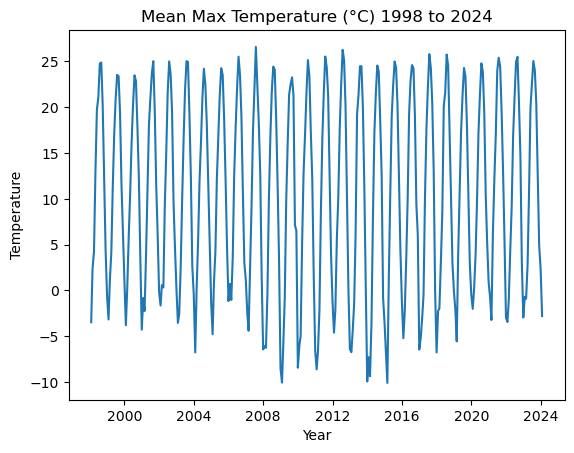

In [28]:
# plot mean max temp
plt.plot(resampled['Mean Max Temp (°C)'])
plt.title('Mean Max Temperature (°C) 1998 to 2024')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.show()

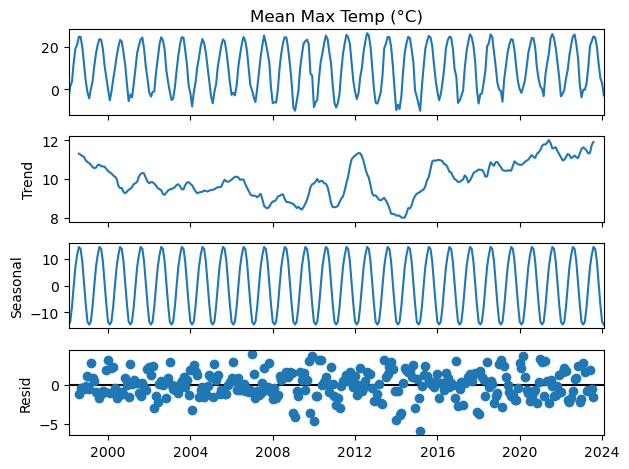

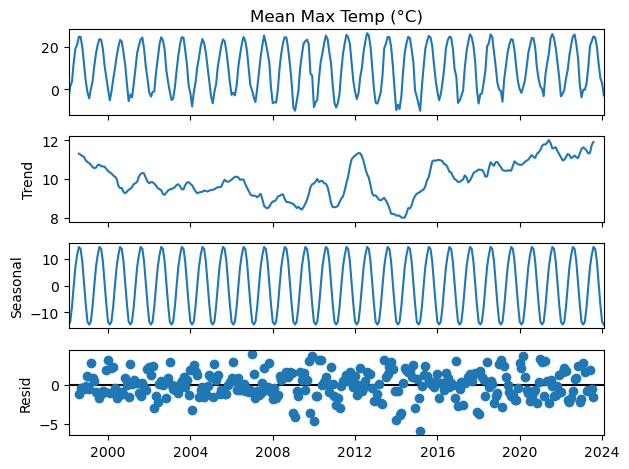

In [ ]:
# seasonal decompose to separate different components (trend, seasonality, and residual)

decomp = seasonal_decompose(resampled['Mean Max Temp (°C)'],
                            period = 12)

decomp.plot()

Dicky-Fuller test

In [ ]:
adfuller_result = adfuller(resampled['Mean Max Temp (°C)'])
test_statistic, p_value, num_lags, num_obs, critical_values, aic = adfuller_result
print(adfuller_result)

# Print ADF test result along with elements
print(f"ADF Test Result:")
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f"Number of Lags: {num_lags}")
print(f"Number of Observations: {num_obs}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")
print(f"Estimated maximized information criterion (aic): {aic}")

if p_value > 0.05:
    print('Data is non-stationary. Needs to be converted to stationary data to use ARIMA.')
else:
    print('\nData is stationary. Can proceed with ARIMA or SARIMAX model creation.')

(-2.555299908314807, 0.1025922009044799, 14, 298, {'1%': -3.4524859843440754, '5%': -2.871288184343229, '10%': -2.571964047565425}, 1228.0356538108726)
ADF Test Result:
Test Statistic: -2.555299908314807
P-value: 0.1025922009044799
Number of Lags: 14
Number of Observations: 298
Critical Values:
  1%: -3.4524859843440754
  5%: -2.871288184343229
  10%: -2.571964047565425
Estimated maximized information criterion (aic): 1228.0356538108726
Data is non-stationary. Needs to be converted to stationary data to use ARIMA.


ACF and PACF

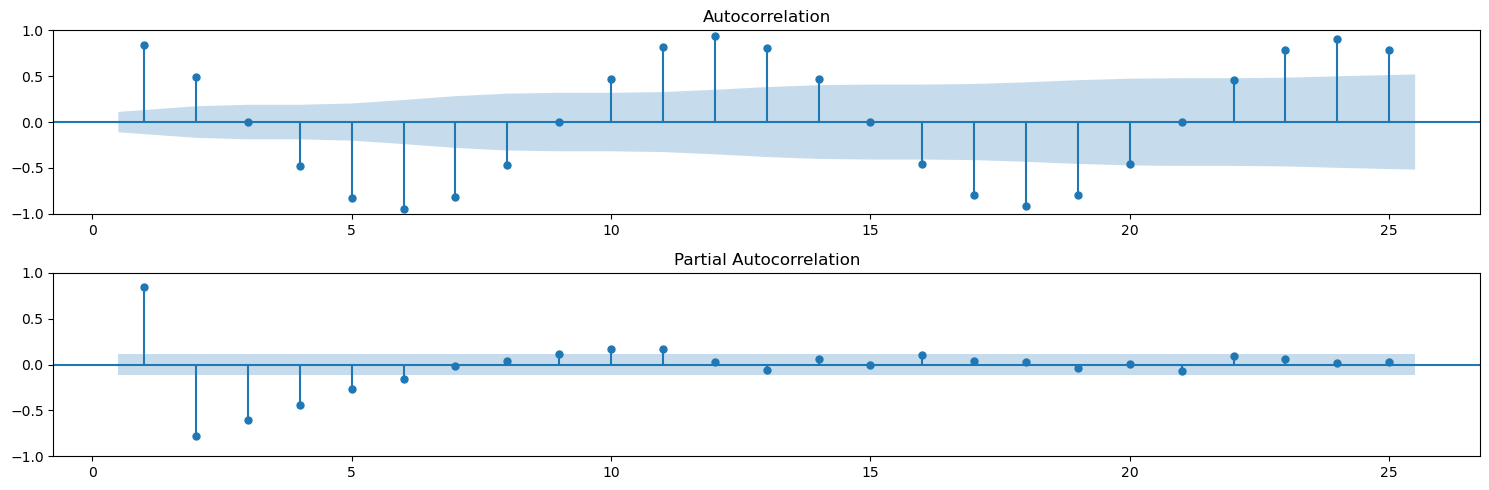

In [ ]:
# create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15, 5))

# plot acf
plot_acf(resampled['Mean Max Temp (°C)'], zero = False, ax = ax1)

# plot pacf
plot_pacf(resampled['Mean Max Temp (°C)'],   zero = False, ax = ax2)

plt.tight_layout()
plt.show()

Split data to train and test dataset for model creation

In [ ]:
# split data to train and test
train = resampled.loc[resampled.index <= '2019-01-01']
test = resampled.loc[resampled.index > '2019-01-01']

print(resampled.shape)
print(train.shape)
print(test.shape)
print(test.index.max())

(313, 20)
(252, 20)
(61, 20)
2024-01-31 00:00:00


In [ ]:
# Create empty list to store search results
order_aic_bic_sarimax = []

# Loop over seasonal parameters (P, D, Q, s)
for P in range(3):  
    for D in range(3):  
        for Q in range(3): 
            # Loop over non-seasonal parameters (p, d, q)
            for p in range(3):
                for q in range(3): 
                    try:
                        # Create and fit SARIMAX(p, d, q)(P, D, Q, s) model
                        model = sm.tsa.SARIMAX(
                            resampled['Mean Max Temp (°C)'],
                            order=(p, 0, q),
                            seasonal_order=(P, D, Q, 12),
                            trend='c'
                        )
                        results = model.fit()

                        # Append order and results tuple
                        order_aic_bic_sarimax.append((p, q, P, D, Q, results.aic, results.bic))
                    except Exception as e:
                        print(f'Error: {e}')
                        

c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\s

In [ ]:
# Construct DataFrame from order_aic_bic
order_df_sarimax = pd.DataFrame(order_aic_bic_sarimax,
                        columns=['p', 'q', 'P', 'D', 'Q', 'AIC', 'BIC'])

order_df_sarimax.sort_values(['AIC', 'BIC'], inplace=True)
print(order_df_sarimax.head())

# Print order_df in order of increasing AIC
print(order_df_sarimax.sort_values('AIC').head())

# Print order_df in order of increasing BIC
print(order_df_sarimax.sort_values('BIC').head())

     p  q  P  D  Q          AIC          BIC
95   1  2  1  0  1    14.000000    40.223422
202  1  1  2  1  1  1258.142990  1284.092762
49   1  1  0  1  2  1258.711779  1280.954441
40   1  1  0  1  1  1258.723267  1277.258818
215  2  2  2  1  2  1258.789546  1295.860649
     p  q  P  D  Q          AIC          BIC
95   1  2  1  0  1    14.000000    40.223422
202  1  1  2  1  1  1258.142990  1284.092762
49   1  1  0  1  2  1258.711779  1280.954441
40   1  1  0  1  1  1258.723267  1277.258818
215  2  2  2  1  2  1258.789546  1295.860649
    p  q  P  D  Q          AIC          BIC
95  1  2  1  0  1    14.000000    40.223422
39  1  0  0  1  1  1262.378288  1277.206729
40  1  1  0  1  1  1258.723267  1277.258818
42  2  0  0  1  1  1260.605953  1279.141504
49  1  1  0  1  2  1258.711779  1280.954441


In [ ]:
# SARIMAX #

p = order_df_sarimax['p'].iloc[0]
print(p)
q = order_df_sarimax['q'].iloc[0]
print(q)
P = order_df_sarimax['P'].iloc[0]
print(P)
D = order_df_sarimax['D'].iloc[0]
print(D)
Q = order_df_sarimax['Q'].iloc[0]
print(Q)


# Instantiate the model
model_sarimax = sm.tsa.SARIMAX(train['Mean Max Temp (°C)'], order=(p, 0, q),
                               seasonal_order = (P, D, Q, 12))

# # Fit the model
results_train_sarimax = model_sarimax.fit()

# Print model fit summary
print(results_train_sarimax.summary())

1
2
1
0
1


c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


                                      SARIMAX Results                                       
Dep. Variable:                   Mean Max Temp (°C)   No. Observations:                  252
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 12)   Log Likelihood                -538.171
Date:                              Fri, 05 Apr 2024   AIC                           1088.342
Time:                                      21:29:02   BIC                           1109.518
Sample:                                  01-31-1998   HQIC                          1096.863
                                       - 12-31-2018                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6211      0.182      3.417      0.001       0.265       0.977
ma.L1         -0.35

In [ ]:
# Make predictions
sarimax_predictions = results_train_sarimax.predict(start=test['Mean Max Temp (°C)'].index[0],
                                             end=test['Mean Max Temp (°C)'].index[-1], 
                                             typ='levels')
print(sarimax_predictions)

2019-01-31    -3.952037
2019-02-28    -3.006954
2019-03-31     2.064106
2019-04-30     9.749998
2019-05-31    18.389738
                ...    
2023-09-30    19.062951
2023-10-31    11.122965
2023-11-30     2.476948
2023-12-31    -4.247597
2024-01-31    -5.067573
Freq: M, Name: predicted_mean, Length: 61, dtype: float64


c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
# to calculate MAE< MAPE and RSME

sarimax_MAE = mean_absolute_error(test['Mean Max Temp (°C)'], sarimax_predictions)
print('Sarimax_MAE:', sarimax_MAE)
sarimax_MAPE = mean_absolute_percentage_error(test['Mean Max Temp (°C)'], sarimax_predictions)
print('Sarimax_MAPE:', sarimax_MAPE)
sarimax_RMSE = np.sqrt(mean_squared_error(test['Mean Max Temp (°C)'], sarimax_predictions))
print('Sarimax_RMSE:', sarimax_RMSE)



Sarimax_MAE: 1.9876416873264935
Sarimax_MAPE: 2.98536498085642
Sarimax_RMSE: 2.5477383139740266


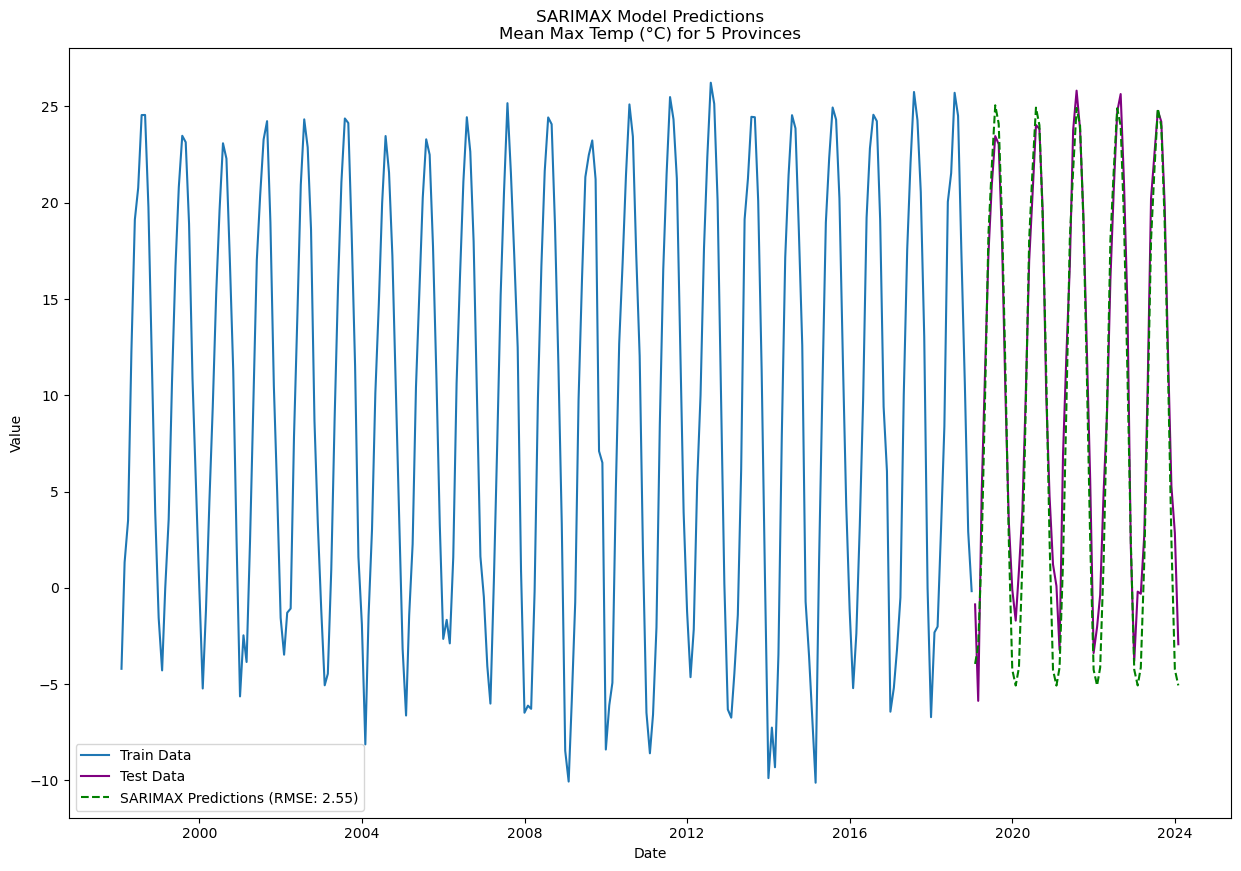

In [ ]:
# Plot actual vs. predicted values
plt.figure(figsize=(15, 10))
plt.plot(train['Mean Max Temp (°C)'].index, train['Mean Max Temp (°C)'], label='Train Data')

plt.plot(test['Mean Max Temp (°C)'].index, test['Mean Max Temp (°C)'], label='Test Data',
         color = 'purple')


plt.plot(test['Mean Max Temp (°C)'].index, sarimax_predictions, 
         label=f'SARIMAX Predictions (RMSE: {sarimax_RMSE:.2f})',
         linestyle='--',
         alpha=1.0,
         color = 'green')

plt.title('SARIMAX Model Predictions\nMean Max Temp (°C) for 5 Provinces',)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

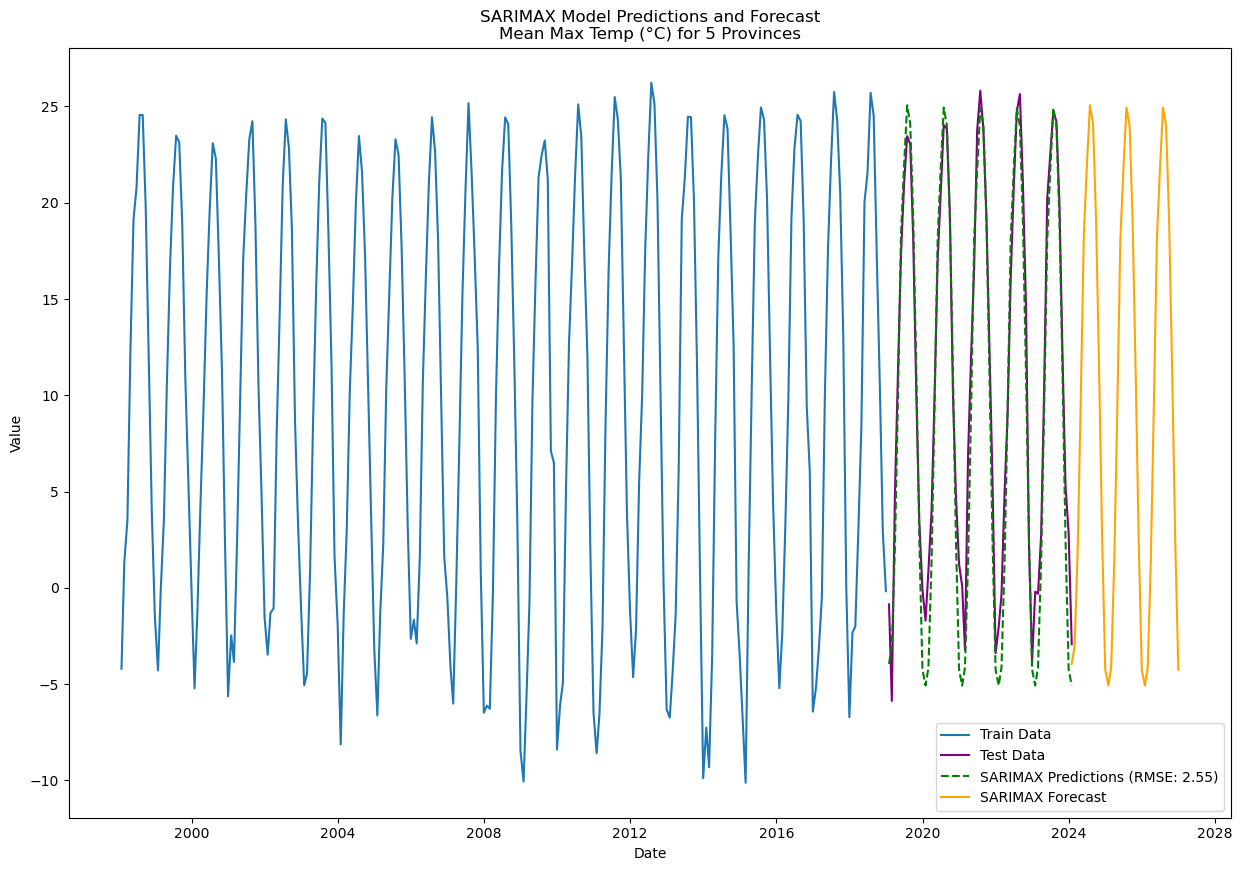

In [ ]:
# Extend the time index to include future dates
future_dates = pd.date_range(start=test.index[-1], periods=36, freq='M')

# Get SARIMAX forecast for future dates
sarimax_forecast = results_train_sarimax.get_forecast(steps=36)

# Plot actual vs. predicted values
plt.figure(figsize=(15, 10))
plt.plot(train['Mean Max Temp (°C)'].index, train['Mean Max Temp (°C)'], label='Train Data')
plt.plot(test['Mean Max Temp (°C)'].index, test['Mean Max Temp (°C)'], label='Test Data', color='purple')
plt.plot(test['Mean Max Temp (°C)'].index, sarimax_predictions, label=f'SARIMAX Predictions (RMSE: {sarimax_RMSE:.2f})', linestyle='--', alpha=1.0, color='green')

# Plot SARIMAX forecast for future dates
plt.plot(future_dates, sarimax_forecast.predicted_mean, label='SARIMAX Forecast', color='orange')



plt.title('SARIMAX Model Predictions and Forecast\nMean Max Temp (°C) for 5 Provinces')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


**(1.2) Forecasting: Mean Min Temp (°C)**

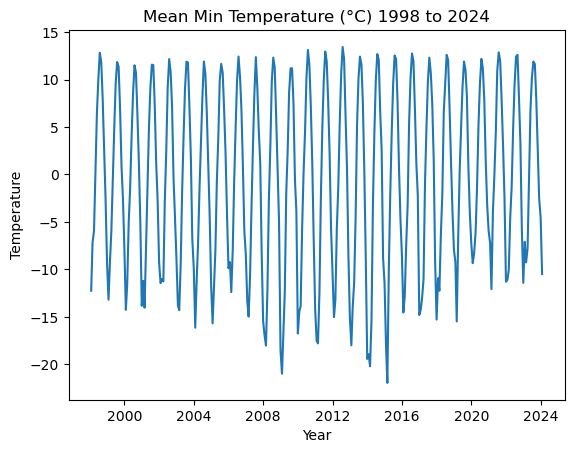

In [ ]:
# plot mean min temp
plt.plot(resampled['Mean Min Temp (°C)'])
plt.title('Mean Min Temperature (°C) 1998 to 2024')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.show()

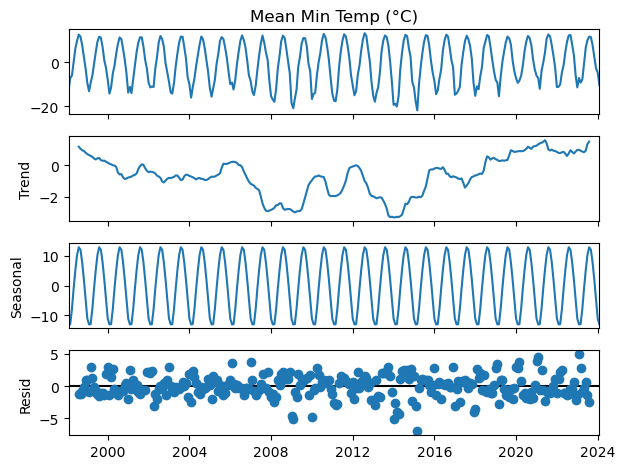

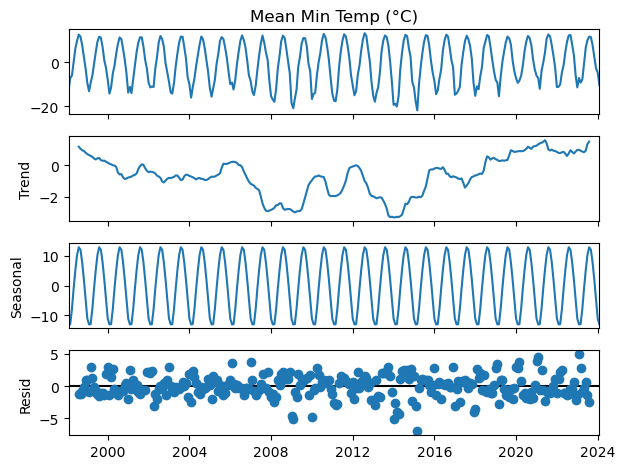

In [ ]:
# seasonal decompose to separate different components (trend, seasonality, and residual)

decomp = seasonal_decompose(resampled['Mean Min Temp (°C)'],
                            period = 12)

decomp.plot()

Dicky-Fuller test

In [ ]:
adfuller_result = adfuller(resampled['Mean Min Temp (°C)'])
test_statistic, p_value, num_lags, num_obs, critical_values, aic = adfuller_result
print(adfuller_result)

# Print ADF test result along with elements
print(f"ADF Test Result:")
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f"Number of Lags: {num_lags}")
print(f"Number of Observations: {num_obs}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")
print(f"Estimated maximized information criterion (aic): {aic}")

if p_value > 0.05:
    print('Data is non-stationary. Needs to be converted to stationary data to use ARIMA.')
else:
    print('\nData is stationary. Can proceed with ARIMA or SARIMAX model creation.')

(-2.40121240907086, 0.14139450755562327, 16, 296, {'1%': -3.452636878592149, '5%': -2.8713543954331433, '10%': -2.5719993576515705}, 1198.9633616128367)
ADF Test Result:
Test Statistic: -2.40121240907086
P-value: 0.14139450755562327
Number of Lags: 16
Number of Observations: 296
Critical Values:
  1%: -3.452636878592149
  5%: -2.8713543954331433
  10%: -2.5719993576515705
Estimated maximized information criterion (aic): 1198.9633616128367
Data is non-stationary. Needs to be converted to stationary data to use ARIMA.


ACF and PACF

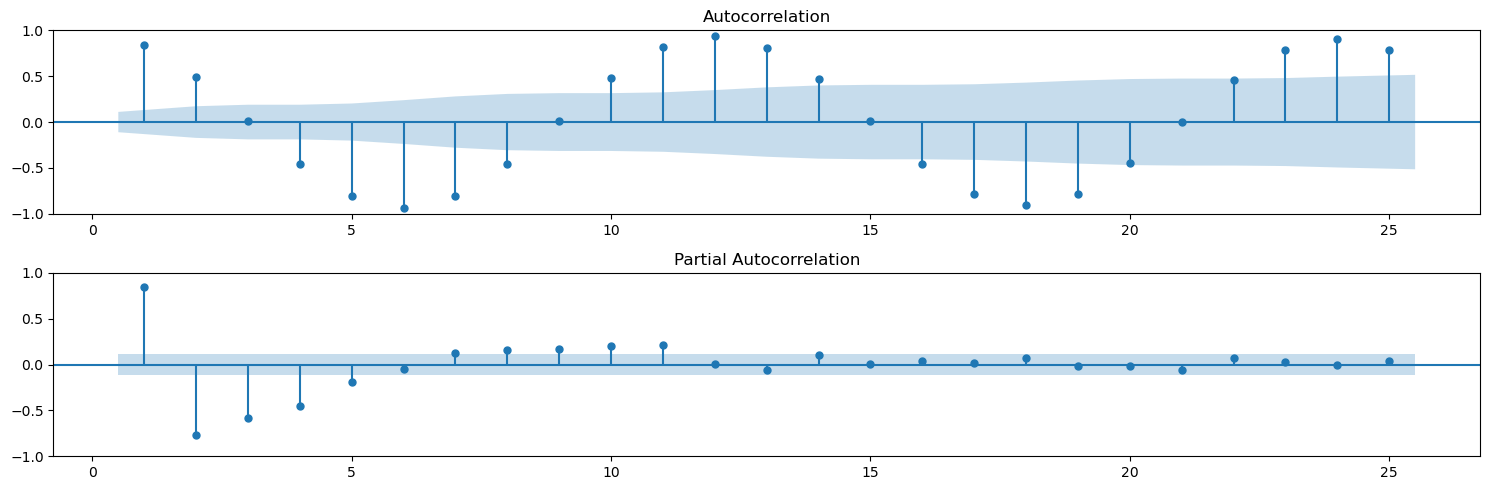

In [ ]:
# create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15, 5))

# plot acf
plot_acf(resampled['Mean Min Temp (°C)'], zero = False, ax = ax1)

# plot pacf
plot_pacf(resampled['Mean Min Temp (°C)'],   zero = False, ax = ax2)

plt.tight_layout()
plt.show()

Split data to train and test dataset for model creation

In [ ]:
# split data to train and test
train = resampled.loc[resampled.index <= '2019-01-01']
test = resampled.loc[resampled.index > '2019-01-01']

print(resampled.shape)
print(train.shape)
print(test.shape)
print(test.index.max())

(313, 20)
(252, 20)
(61, 20)
2024-01-31 00:00:00


In [ ]:
# Create empty list to store search results
order_aic_bic_sarimax = []

# Loop over seasonal parameters (P, D, Q, s)
for P in range(3):  
    for D in range(3):  
        for Q in range(3): 
            # Loop over non-seasonal parameters (p, d, q)
            for p in range(3):
                for q in range(3): 
                    try:
                        # Create and fit SARIMAX(p, d, q)(P, D, Q, s) model
                        model = sm.tsa.SARIMAX(
                            resampled['Mean Min Temp (°C)'],
                            order=(p, 0, q),
                            seasonal_order=(P, D, Q, 12),
                            trend='c'
                        )
                        results = model.fit()

                        # Append order and results tuple
                        order_aic_bic_sarimax.append((p, q, P, D, Q, results.aic, results.bic))
                    except Exception as e:
                        print(f'Error: {e}')
                        

c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\chust\anaconda3\Lib\s

In [ ]:
# Construct DataFrame from order_aic_bic
order_df_sarimax = pd.DataFrame(order_aic_bic_sarimax,
                        columns=['p', 'q', 'P', 'D', 'Q', 'AIC', 'BIC'])

order_df_sarimax.sort_values(['AIC', 'BIC'], inplace=True)
print(order_df_sarimax.head())

# Print order_df in order of increasing AIC
print(order_df_sarimax.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df_sarimax.sort_values('BIC'))

     p  q  P  D  Q          AIC          BIC
48   1  0  0  1  2  1276.674452  1295.210003
201  1  0  2  1  1  1277.119799  1299.362460
120  1  0  1  1  1  1277.538645  1296.074196
129  1  0  1  1  2  1278.107652  1300.350314
52   2  1  0  1  2  1278.572400  1304.522172
..  .. .. .. .. ..          ...          ...
2    0  2  0  0  0  1833.718677  1848.703489
3    1  0  0  0  0  1896.066024  1907.304633
1    0  1  0  0  0  1977.909785  1989.148395
9    0  0  0  0  1  1992.588665  2003.827274
0    0  0  0  0  0  2279.248724  2286.741130

[243 rows x 7 columns]
     p  q  P  D  Q          AIC          BIC
39   1  0  0  1  1  1279.319936  1294.148377
48   1  0  0  1  2  1276.674452  1295.210003
120  1  0  1  1  1  1277.538645  1296.074196
37   0  1  0  1  1  1282.460184  1297.288625
46   0  1  0  1  2  1279.088571  1297.624122
..  .. .. .. .. ..          ...          ...
2    0  2  0  0  0  1833.718677  1848.703489
3    1  0  0  0  0  1896.066024  1907.304633
1    0  1  0  0  0  1977.909785

In [ ]:
# SARIMAX #

p = order_df_sarimax['p'].iloc[0]
print(p)
q = order_df_sarimax['q'].iloc[0]
print(q)
P = order_df_sarimax['P'].iloc[0]
print(P)
D = order_df_sarimax['D'].iloc[0]
print(D)
Q = order_df_sarimax['Q'].iloc[0]
print(Q)

# Instantiate the model
model_sarimax = sm.tsa.SARIMAX(train['Mean Min Temp (°C)'], order=(p, 0, q),
                               seasonal_order = (P, D, Q, 12))

# # Fit the model
results_train_sarimax = model_sarimax.fit()

# Print model fit summary
print(results_train_sarimax.summary())

    p  q  P  D  Q          AIC          BIC
48  1  0  0  1  2  1276.674452  1295.210003
1
0
0
1
2


c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                        SARIMAX Results                                        
Dep. Variable:                      Mean Min Temp (°C)   No. Observations:                  252
Model:             SARIMAX(1, 0, 0)x(0, 1, [1, 2], 12)   Log Likelihood                -507.685
Date:                                 Thu, 04 Apr 2024   AIC                           1023.369
Time:                                         00:09:19   BIC                           1037.292
Sample:                                     01-31-1998   HQIC                          1028.979
                                          - 12-31-2018                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3512      0.050      7.048      0.000       0.254       0

In [ ]:
# Make predictions
sarimax_predictions = results_train_sarimax.predict(start=test['Mean Min Temp (°C)'].index[0],
                                             end=test['Mean Min Temp (°C)'].index[-1], 
                                             typ='levels')
print(sarimax_predictions)

2019-01-31   -12.409000
2019-02-28   -12.223920
2019-03-31    -7.978080
2019-04-30    -1.486193
2019-05-31     5.512018
                ...    
2023-09-30     8.755100
2023-10-31     2.295884
2023-11-30    -4.667928
2023-12-31   -10.270495
2024-01-31   -13.011022
Freq: M, Name: predicted_mean, Length: 61, dtype: float64
2019-01-31   -12.128313
2019-02-28   -12.605579
2019-03-31    -7.715398
2019-04-30    -1.107269
2019-05-31     6.144186
                ...    
2023-09-30     8.273068
2023-10-31     2.708651
2023-11-30    -3.335963
2023-12-31    -9.748842
2024-01-31   -13.409781
Freq: M, Name: predicted_mean, Length: 61, dtype: float64


c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [ ]:
# to calculate MAE< MAPE and RSME
sarimax_MAE = mean_absolute_error(test['Mean Min Temp (°C)'], sarimax_predictions)
print('Sarimax_MAE:', sarimax_MAE)
sarimax_MAPE = mean_absolute_percentage_error(test['Mean Min Temp (°C)'], sarimax_predictions)
print('Sarimax_MAPE:', sarimax_MAPE)
sarimax_RMSE = np.sqrt(mean_squared_error(test['Mean Min Temp (°C)'], sarimax_predictions))
print('Sarimax_RMSE:', sarimax_RMSE)



Arima_MAE: 1.7835211010067973
Arima_MAPE: 0.7250181568134052
Arima_RMSE: 2.3013624648923328
Sarimax_MAE: 1.6346119578148577
Sarimax_MAPE: 0.5458339363230127
Sarimax_RMSE: 2.267291231893572


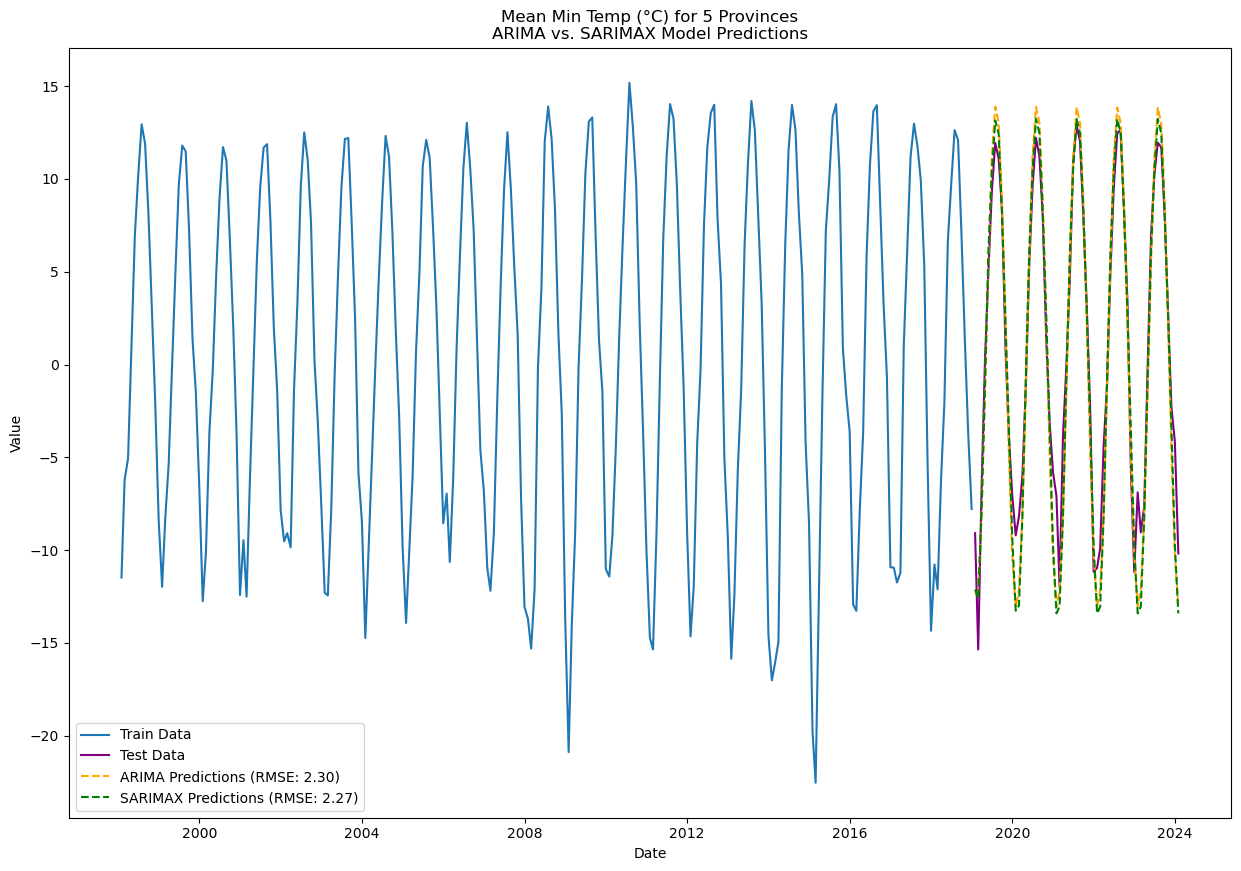

In [ ]:
# Plot actual vs. predicted values
plt.figure(figsize=(15, 10))
plt.plot(train['Mean Min Temp (°C)'].index, train['Mean Min Temp (°C)'], label='Train Data')

plt.plot(test['Mean Min Temp (°C)'].index, test['Mean Min Temp (°C)'], label='Test Data',
         color = 'purple')


plt.plot(test['Mean Min Temp (°C)'].index, sarimax_predictions, 
         label=f'SARIMAX Predictions (RMSE: {sarimax_RMSE:.2f})',
         linestyle='--',
         alpha=1.0,
         color = 'green')

plt.title('SARIMAX Model Predictions\nMean Max Temp (°C) for 5 Provinces',)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

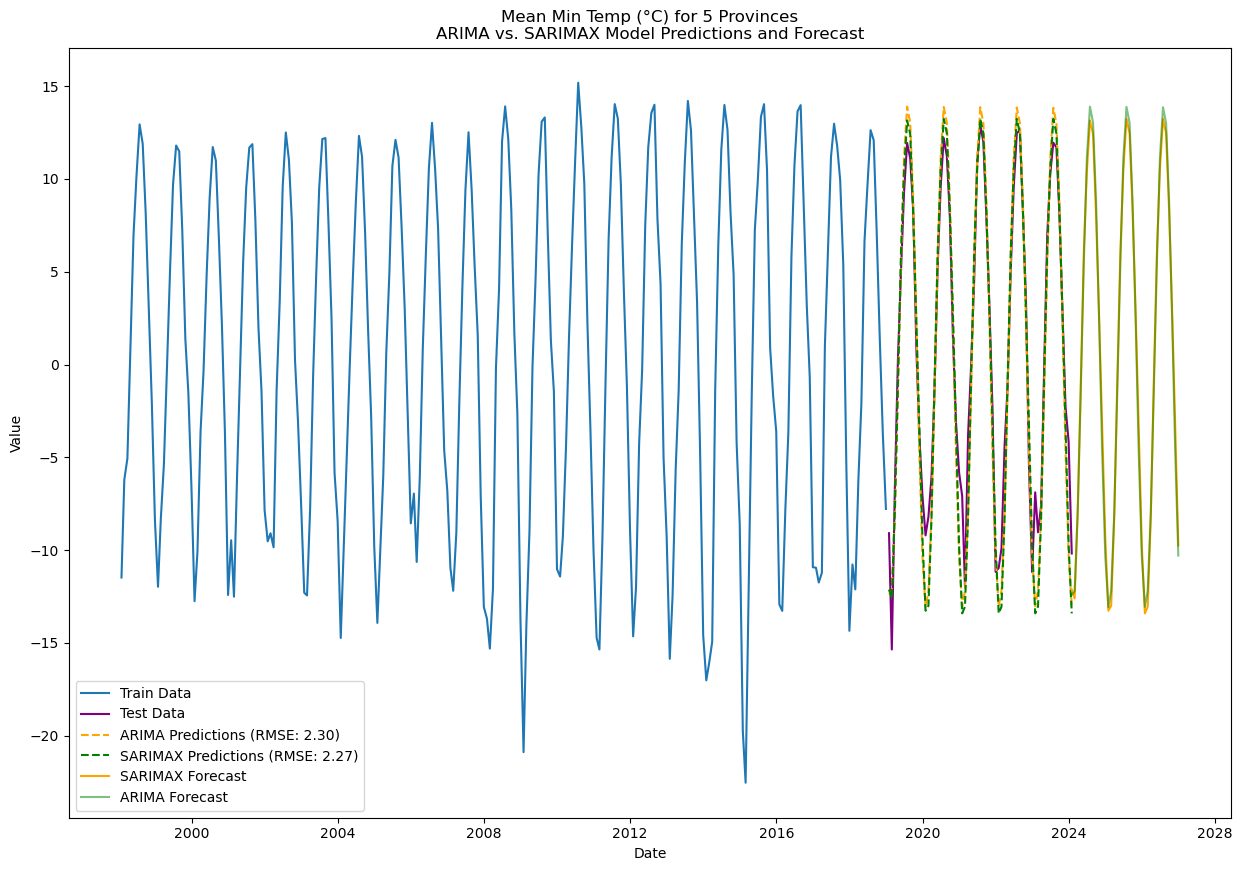

In [ ]:
# Extend the time index to include future dates
future_dates = pd.date_range(start=test.index[-1], periods=36, freq='M')


# Get SARIMAX forecast for future dates
sarimax_forecast = results_train_sarimax.get_forecast(steps=36)

# Plot actual vs. predicted values
plt.figure(figsize=(15, 10))
plt.plot(train['Mean Min Temp (°C)'].index, train['Mean Min Temp (°C)'], label='Train Data')
plt.plot(test['Mean Min Temp (°C)'].index, test['Mean Min Temp (°C)'], label='Test Data', color='purple')
plt.plot(test['Mean Min Temp (°C)'].index, sarimax_predictions, label=f'SARIMAX Predictions (RMSE: {sarimax_RMSE:.2f})', linestyle='--', alpha=1.0, color='green')

# Plot SARIMAX forecast for future dates
plt.plot(future_dates, sarimax_forecast.predicted_mean, label='SARIMAX Forecast', color='orange')

plt.title('SARIMAX Model Predictions and Forecast\nMean Max Temp (°C) for 5 Provinces')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


**(1.3) Forecasting: Mean Temp (°C)**

In [ ]:
# plot mean max temp
plt.plot(resampled['Mean Temp (°C)'])
plt.title('Mean Temp (°C) 1998 to 2024')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.show()

In [ ]:
# seasonal decompose to separate different components (trend, seasonality, and residual)

decomp = seasonal_decompose(resampled['Mean Temp (°C)'],
                            period = 12)

decomp.plot()

Dicky-Fuller test

In [ ]:
adfuller_result = adfuller(resampled['Mean Temp (°C)'])
test_statistic, p_value, num_lags, num_obs, critical_values, aic = adfuller_result
print(adfuller_result)

# Print ADF test result along with elements
print(f"ADF Test Result:")
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f"Number of Lags: {num_lags}")
print(f"Number of Observations: {num_obs}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")
print(f"Estimated maximized information criterion (aic): {aic}")

if p_value > 0.05:
    print('Data is non-stationary. Needs to be converted to stationary data to use ARIMA.')
else:
    print('\nData is stationary. Can proceed with ARIMA or SARIMAX model creation.')

(-2.555299908314807, 0.1025922009044799, 14, 298, {'1%': -3.4524859843440754, '5%': -2.871288184343229, '10%': -2.571964047565425}, 1228.0356538108726)
ADF Test Result:
Test Statistic: -2.555299908314807
P-value: 0.1025922009044799
Number of Lags: 14
Number of Observations: 298
Critical Values:
  1%: -3.4524859843440754
  5%: -2.871288184343229
  10%: -2.571964047565425
Estimated maximized information criterion (aic): 1228.0356538108726
Data is non-stationary. Needs to be converted to stationary data to use ARIMA.


ACF and PACF

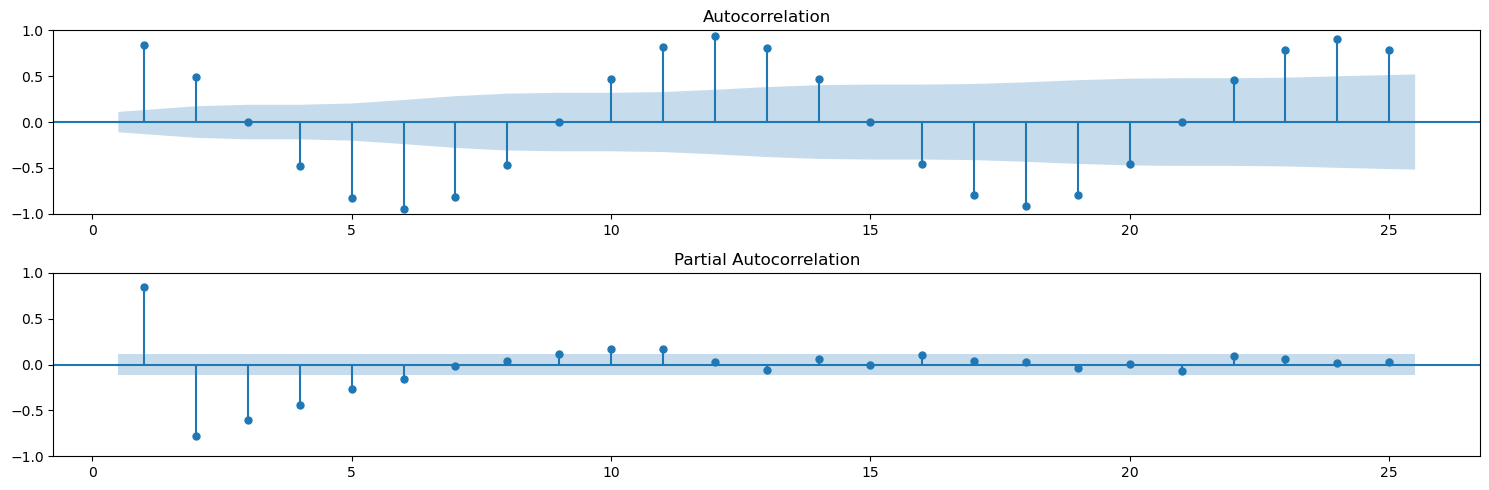

In [ ]:
# create figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15, 5))

# plot acf
plot_acf(resampled['Mean Temp (°C)'], zero = False, ax = ax1)

# plot pacf
plot_pacf(resampled['Mean Temp (°C)'],   zero = False, ax = ax2)

plt.tight_layout()
plt.show()

Split data to train and test dataset for model creation

In [ ]:
# split data to train and test
train = resampled.loc[resampled.index <= '2019-01-01']
test = resampled.loc[resampled.index > '2019-01-01']

print(resampled.shape)
print(train.shape)
print(test.shape)
print(test.index.max())

(313, 20)
(252, 20)
(61, 20)
2024-01-31 00:00:00


## Ontario ##

**Forecasting: Agriculture**

In [ ]:
# to filter ON province:

ontario = df[df['provincename'] == 'Ontario']

In [ ]:
ontario = ontario[ontario.index.year < 2022]

In [ ]:
# split data into number and object
num_cols = ontario.select_dtypes(include = ['number'])
cat_cols = ontario.select_dtypes(include = ['object'])

# to resample num data into monthly frequency
resampled_num = num_cols.resample(rule = 'M').mean()

# to resample cat data into monthly frequency
resampled_cat = cat_cols.resample(rule = 'M').apply(lambda x: x.value_counts().idxmax())

# combine resampled num and cat data
resampled_ON = pd.concat([resampled_num, resampled_cat], axis = 1)

In [ ]:
ontario.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8701 entries, 1998-01-01 to 2021-12-01
Data columns (total 25 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   provincename                                                                       8701 non-null   object 
 1   Longitude                                                                          8701 non-null   float64
 2   Latitude                                                                           8701 non-null   float64
 3   Region.Name                                                                        8701 non-null   object 
 4   Construction                                                                       8701 non-null   float64
 5   Manufacturing                                                                      870

In [ ]:
print(ontario.index.min())
print(ontario.index.max())

1998-01-01 00:00:00
2021-12-01 00:00:00


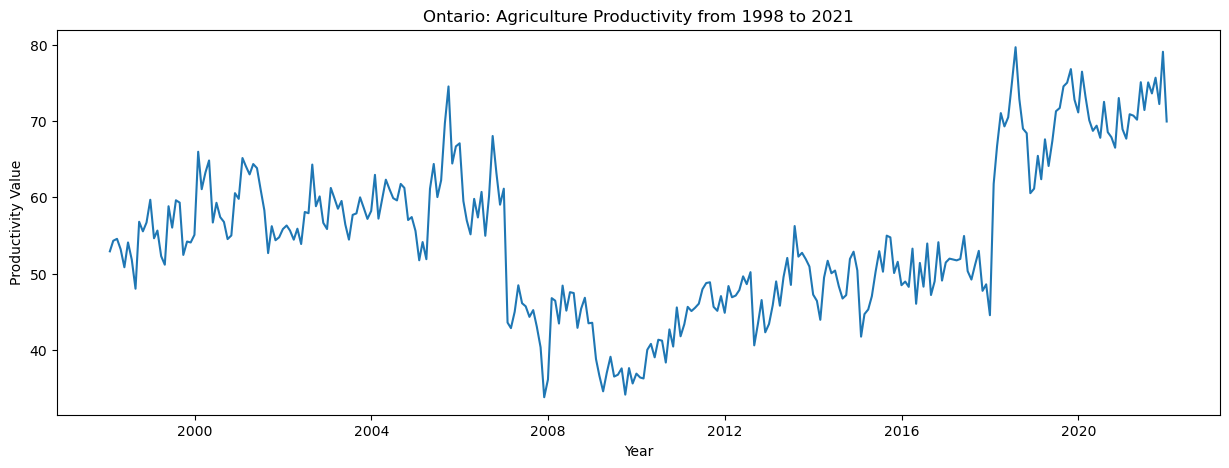

In [ ]:
# plot the utililities
plt.figure(figsize = (15, 5))
plt.plot(resampled_ON['Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction'])
plt.title('Ontario: Agriculture Productivity from 1998 to 2021')
plt.xlabel('Year')
plt.ylabel('Productivity Value')
plt.show()

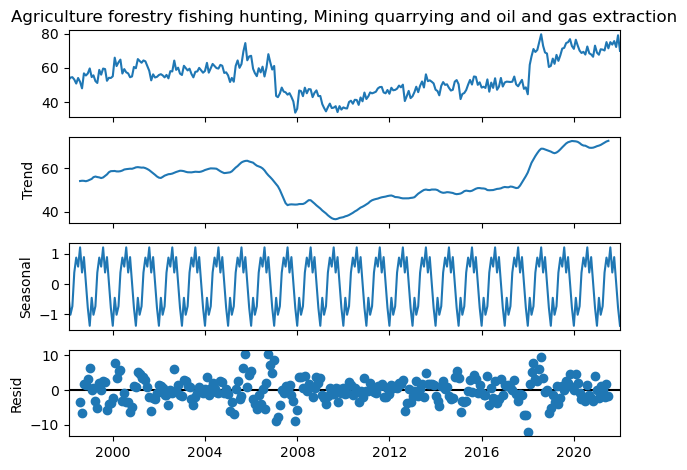

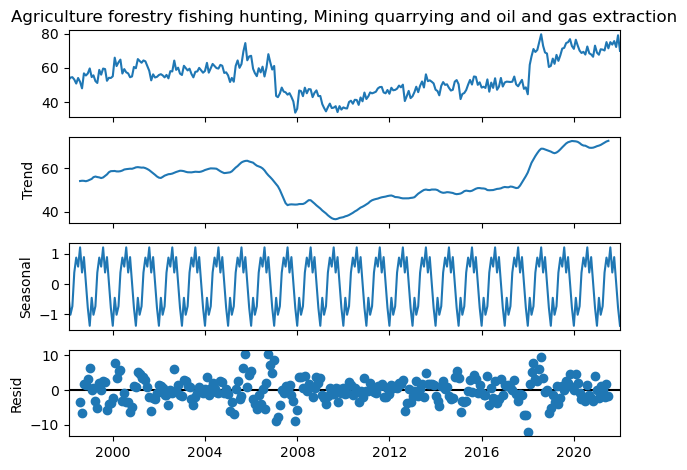

In [ ]:
# to check different components (trend, seasonality, and residual)

decomp_ON = seasonal_decompose(resampled_ON['Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction'],
                               period = 12)

decomp_ON.plot()

Dicky-Fuller Test

In [ ]:
adfuller_result = adfuller(resampled_ON['Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction'])
adfuller_result = adfuller(resampled_ON['Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction'])
test_statistic, p_value, num_lags, num_obs, critical_values, aic = adfuller_result
print(adfuller_result)

# Print ADF test result along with elements
print(f"ADF Test Result:")
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f"Number of Lags: {num_lags}")
print(f"Number of Observations: {num_obs}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")
print(f"Estimated maximized information criterion (aic): {aic}")

if p_value > 0.05:
    print('Data is non-stationary. Needs to be converted to stationary data.')
else:
    print('Data is stationary. Can proceed with model creation.')

(-2.2244320044855024, 0.19749783622467093, 1, 286, {'1%': -3.4534232986669546, '5%': -2.8716994185534745, '10%': -2.5721833625116144}, 1483.2074409605557)
ADF Test Result:
Test Statistic: -2.2244320044855024
P-value: 0.19749783622467093
Number of Lags: 1
Number of Observations: 286
Critical Values:
  1%: -3.4534232986669546
  5%: -2.8716994185534745
  10%: -2.5721833625116144
Estimated maximized information criterion (aic): 1483.2074409605557
Data is non-stationary. Needs to be converted to stationary data.


In [ ]:
# transforming data to stationary data

# differencing

resampled_ON_diff = resampled_ON['Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction'].diff(periods = 2).dropna()
resampled_ON_diff

Date/Time
1998-03-31    1.640896
1998-04-30   -1.110992
1998-05-31   -3.733965
1998-06-30    0.890058
1998-07-31    1.002426
                ...   
2021-08-31    2.178425
2021-09-30    0.614057
2021-10-31   -1.394894
2021-11-30    3.409796
2021-12-31   -2.291200
Freq: M, Name: Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction, Length: 286, dtype: float64

In [ ]:
adfuller_result = adfuller(resampled_ON_diff)
test_statistic, p_value, num_lags, num_obs, critical_values, aic = adfuller_result
print(adfuller_result)

# Print ADF test result along with elements
print(f"ADF Test Result:")
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f"Number of Lags: {num_lags}")
print(f"Number of Observations: {num_obs}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"  {key}: {value}")
print(f"Estimated maximized information criterion (aic): {aic}")

if p_value > 0.05:
    print('Data is non-stationary. Needs to be converted to stationary data.')
else:
    print('Data is stationary. Can proceed with model creation.')

(-4.411990290013513, 0.00028266033924551895, 14, 271, {'1%': -3.4547128138328875, '5%': -2.8722649771800155, '10%': -2.5724850011573914}, 1484.4594978642592)
ADF Test Result:
Test Statistic: -4.411990290013513
P-value: 0.00028266033924551895
Number of Lags: 14
Number of Observations: 271
Critical Values:
  1%: -3.4547128138328875
  5%: -2.8722649771800155
  10%: -2.5724850011573914
Estimated maximized information criterion (aic): 1484.4594978642592
Data is stationary. Can proceed with model creation.


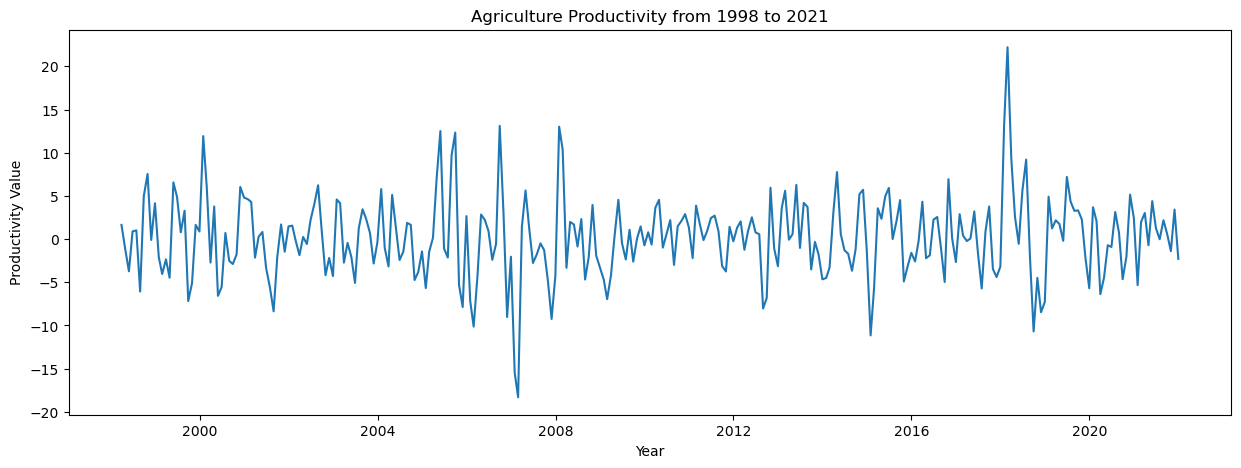

In [ ]:
# plotting the transformed data

# plot the utililities
plt.figure(figsize = (15, 5))
plt.plot(resampled_ON_diff)
plt.title('Agriculture Productivity from 1998 to 2021')
plt.xlabel('Year')
plt.ylabel('Productivity Value')
plt.show()

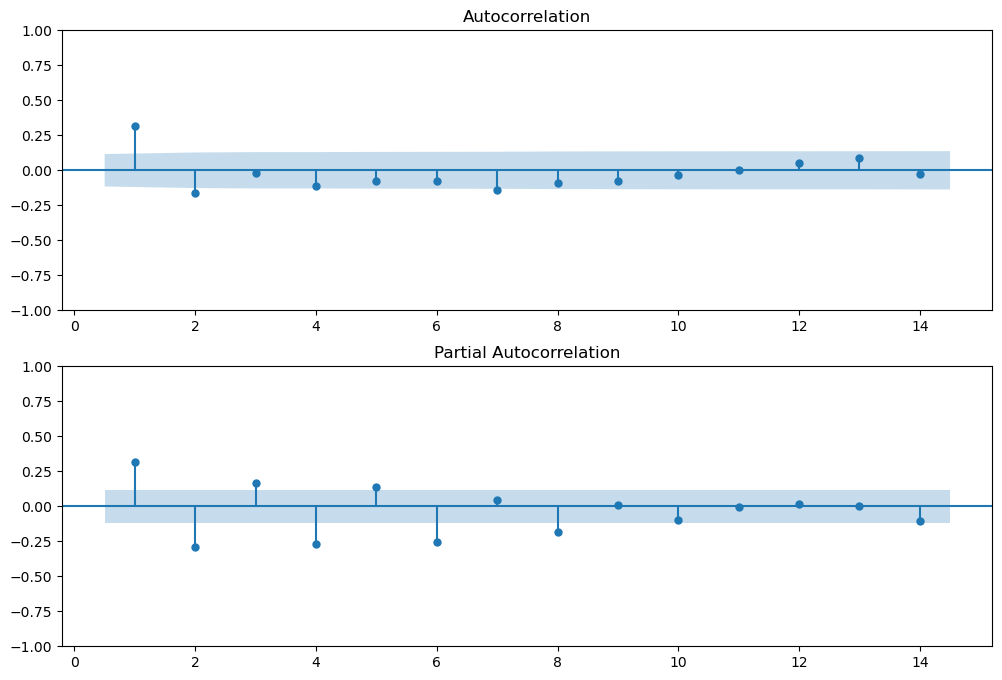

In [ ]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot the ACF on ax1
plot_acf(resampled_ON_diff, lags=14, zero=False, ax=ax1)
# plot_acf(resampled_ON_diff, zero=False, ax=ax1)

# Plot the PACF of on ax2
plot_pacf(resampled_ON_diff, lags=14, zero=False, ax=ax2)
# plot_pacf(resampled_ON_diff, zero=False, ax=ax2)

plt.show()

SARIMAX MODEL

In [ ]:
# from pmdarima.arima import auto_arima

# model = auto_arima(resampled_ON_diff, start_p=1, start_q=1,
#                       test='adf',
#                       max_p=14, max_q=14,
#                       m=1,             
#                       d=0,          
#                       seasonal=False,   
#                       start_P=0, 
#                       D=None, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)

In [ ]:
# Create empty list to store search results
order_aic_bic=[]
# Loop over p values (Use the partial autocorrelation)
for p in range(14):
# Loop over q values (Use the autocorrelation)
    for q in range(14):
        try:
            # Create and fit SARIMAX(p,d,q) model
            model = sm.tsa.SARIMAX(resampled_ON_diff, order=(p,0,q), trend='c')
            results = model.fit()
            # Append order and results tuple
            order_aic_bic.append((p,q,results.aic, results.bic))
        except:
            print(p, q, None, None)

c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\chust\anaconda3\Lib\site-packages\statsmodels\tsa\state

In [ ]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic,
                        columns=['p', 'q', 'AIC', 'BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values('AIC'))

# Print order_df in order of increasing BIC
print(order_df.sort_values('BIC'))

    p  q          AIC          BIC
32  2  4  1565.441658  1594.689593
59  4  3  1566.219836  1599.123763
60  4  4  1566.410394  1602.970312
5   0  5  1566.918215  1592.510157
62  4  6  1567.063181  1610.935083
.. .. ..          ...          ...
56  4  0  1617.274432  1639.210383
42  3  0  1637.087636  1655.367595
28  2  0  1643.554348  1658.178315
14  1  0  1667.317647  1678.285623
0   0  0  1695.993818  1703.305802

[196 rows x 4 columns]
      p   q          AIC          BIC
2     0   2  1569.495489  1584.119456
16    1   2  1568.097078  1586.377037
15    1   1  1571.952662  1586.576630
30    2   2  1567.219652  1589.155603
29    2   1  1570.902784  1589.182743
..   ..  ..          ...          ...
193  13  11  1585.711275  1680.767062
180  12  12  1587.024276  1682.080063
194  13  12  1589.525255  1688.237034
195  13  13  1589.634709  1692.002480
0     0   0  1695.993818  1703.305802

[196 rows x 4 columns]


In [ ]:
#to check the minimum value in the dataframe
print("AIC_min:", order_df.AIC.min())

#to check the minimum value in the dataframe
print('BIC_min:', order_df.BIC.min())

AIC_min: 1565.4416584279572
BIC_min: 1584.119455815274


In [ ]:
# Instantiate the model

model = sm.tsa.SARIMAX(resampled_ON_diff, order=(2, 0, 4)) #order=(p,d,q)

# Fit the model
results = model.fit()

# Print model fit summary
print(results.summary())

                                                               SARIMAX Results                                                               
Dep. Variable:     Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction   No. Observations:                  286
Model:                                                                              SARIMAX(2, 0, 4)   Log Likelihood                -774.931
Date:                                                                               Thu, 04 Apr 2024   AIC                           1563.862
Time:                                                                                       00:20:43   BIC                           1589.454
Sample:                                                                                   03-31-1998   HQIC                          1574.120
                                                                                        - 12-31-2021                                         
Covari

In [ ]:
# Generate predictions
one_step_forecast = results.get_prediction(start=-48)

# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = one_step_forecast.conf_int()

confidence_intervals.head().T
# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction']
upper_limits = confidence_intervals.loc[:,'upper Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction']

# Print best estimate predictions
print(mean_forecast)

Date/Time
2018-01-31    -1.868159
2018-02-28    12.183818
2018-03-31     2.872523
2018-04-30     1.024483
2018-05-31    -2.195906
2018-06-30    -1.542246
2018-07-31     1.632003
2018-08-31    -0.151058
2018-09-30    -7.020578
2018-10-31    -5.362755
2018-11-30    -1.075766
2018-12-31    -7.053480
2019-01-31     1.516113
2019-02-28     3.191211
2019-03-31    -0.522827
2019-04-30     4.882944
2019-05-31    -0.123655
2019-06-30     3.676642
2019-07-31     4.953293
2019-08-31     0.427022
2019-09-30     3.141274
2019-10-31    -0.635928
2019-11-30     1.058332
2019-12-31    -4.766914
2020-01-31    -1.831696
2020-02-29     1.721384
2020-03-31    -3.701273
2020-04-30    -4.064375
2020-05-31    -1.134354
2020-06-30    -0.528222
2020-07-31    -0.590195
2020-08-31     3.111674
2020-09-30    -1.757663
2020-10-31     0.026091
2020-11-30     1.050431
2020-12-31     5.172038
2021-01-31    -1.429212
2021-02-28    -0.510798
2021-03-31     3.913524
2021-04-30    -0.643512
2021-05-31     0.431101
2021-0

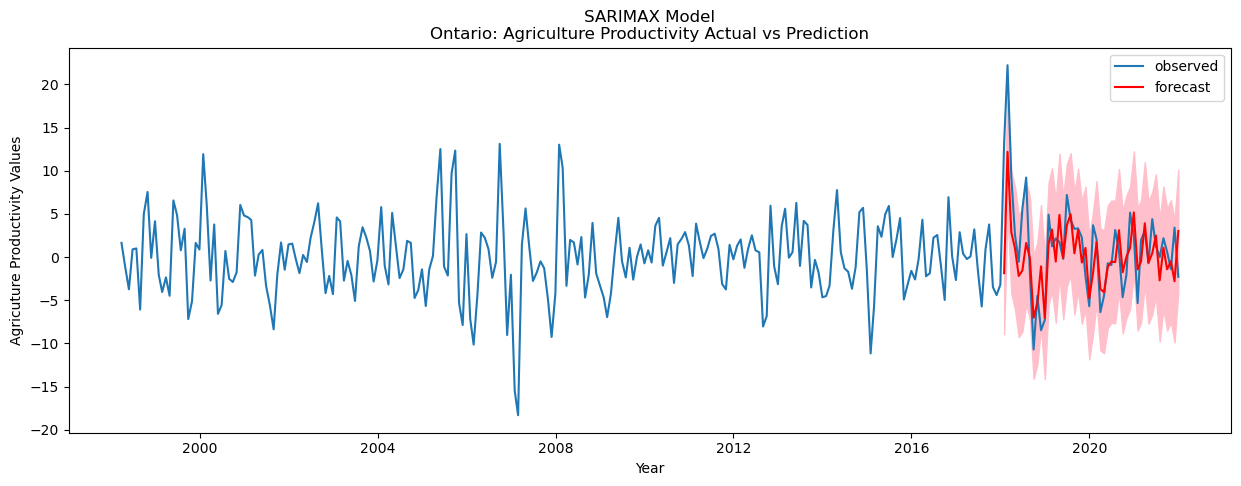

In [ ]:
# plot the  data
plt.figure(figsize = (15, 5))
plt.plot(resampled_ON_diff.index, resampled_ON_diff, label='observed')

# plot your mean predictions
plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

# shade the area between your confidence limits
plt.fill_between(lower_limits.index, lower_limits,
               upper_limits, color='pink')

# set labels, legends and show plot
plt.title('SARIMAX Model\nOntario: Agriculture Productivity Actual vs Prediction')
plt.xlabel('Year')
plt.ylabel('Agricuture Productivity Values')
plt.legend()
plt.show()

In [ ]:
# to calculate MAE, MAPE and RSME
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

sarimax_MAE = mean_absolute_error(resampled_ON_diff.loc['2018-01-31': '2021-12-31'], mean_forecast)
print('Sarimax_MAE:', sarimax_MAE)

sarimax_MAPE = mean_absolute_percentage_error(resampled_ON_diff.loc['2018-01-31': '2021-12-31'], mean_forecast)
print('Sarimax_MAPE:', sarimax_MAPE)

sarimax_RMSE = np.sqrt(mean_squared_error(resampled_ON_diff.loc['2018-01-31': '2021-12-31'], mean_forecast))
print('Sarimax_RMSE:', sarimax_RMSE)


Sarimax_MAE: 3.0718825648925105
Sarimax_MAPE: 3.5399474047469717
Sarimax_RMSE: 4.190332666109481


IGNORE BELOW

Split data to train and test dataset

In [ ]:
# split data to train and test

train = resampled_ON_diff.loc[resampled_ON_diff.index <= '2020-01-01']
test = resampled_ON_diff.loc[resampled_ON_diff.index > '2020-01-01']

In [ ]:
#to fit the model after splitting the data

# Instantiate the model
model = sm.tsa.ARIMA(train, order=(1, 1, 2)) #order=(p,d,q)

# Fit the model
results = model.fit()


In [ ]:
#get the predictions
predictions = results.get_forecast(steps=24)
# Extract prediction mean
mean_predictions =predictions.predicted_mean
print(mean_predictions)

2020-01-31   -1.047747
2020-02-29    0.411891
2020-03-31    0.078637
2020-04-30    0.154723
2020-05-31    0.137352
2020-06-30    0.141318
2020-07-31    0.140412
2020-08-31    0.140619
2020-09-30    0.140572
2020-10-31    0.140583
2020-11-30    0.140580
2020-12-31    0.140581
2021-01-31    0.140581
2021-02-28    0.140581
2021-03-31    0.140581
2021-04-30    0.140581
2021-05-31    0.140581
2021-06-30    0.140581
2021-07-31    0.140581
2021-08-31    0.140581
2021-09-30    0.140581
2021-10-31    0.140581
2021-11-30    0.140581
2021-12-31    0.140581
Freq: M, Name: predicted_mean, dtype: float64


In [ ]:
test.loc['2020-01-31': '2021-12-31']

Date/Time
2020-01-31    3.679435
2020-02-29    2.061321
2020-03-31   -6.376970
2020-04-30   -4.479538
2020-05-31   -0.716047
2020-06-30   -0.913497
2020-07-31    3.130181
2020-08-31    0.742083
2020-09-30   -4.645830
2020-10-31   -2.043999
2020-11-30    5.147226
2020-12-31    2.429975
2021-01-31   -5.337960
2021-02-28    1.969515
2021-03-31    3.022793
2021-04-30   -0.717823
2021-05-31    4.392208
2021-06-30    1.269769
2021-07-31   -0.021380
2021-08-31    2.178425
2021-09-30    0.614057
2021-10-31   -1.394894
2021-11-30    3.409796
2021-12-31   -2.291200
Freq: M, Name: Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction, dtype: float64

In [ ]:
# to calculate MAPE and RSME
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

arima_MAE = mean_absolute_error(test, mean_predictions)
print('Arima_MAE:', arima_MAE)

arima_MAPE = mean_absolute_percentage_error(test, mean_predictions)
print('Arima_MAPE:', arima_MAPE)

arima_RMSE = np.sqrt(mean_squared_error(test, mean_predictions))
print('Arima_RMSE:', arima_RMSE)


Arima_MAE: 2.648816948157504
Arima_MAPE: 1.27592026524311
Arima_RMSE: 3.178484983346455


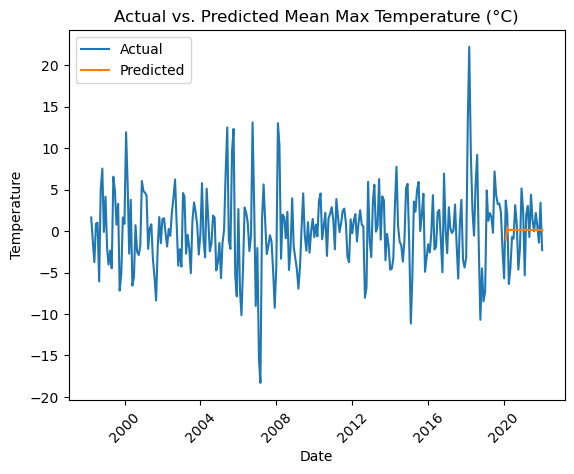

In [ ]:
# plot actual data and predictions

plt.plot(resampled_ON_diff.index, resampled_ON_diff, label='Actual')

plt.plot(mean_predictions.index, mean_predictions.values, label='Predicted')

plt.title('Actual vs. Predicted Mean Max Temperature (°C)')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.xticks(rotation=45)

plt.show()